In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
from numpy import linalg as LA
from scipy.spatial import distance
from scipy.linalg import subspace_angles
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net)

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools
from tools_lnd import plot_N, plot_FP, gen_trials_from_model_dir, name_best_ckpt, gen_X_from_model_dir_epoch, angle_btwe, rot_mat, tranform_in_rPC

ImportError: cannot import name angle_btwe

In [ ]:
rule_set = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_set_names = ['DelayGo', 'ReactGo', 'MemoryGo', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'Decison1', 'Decison2', 'ContextDecison1', 'ContextDecison2', 'MultiDecison',
              'DelayDecison1', 'DelayDecison2', 'ContextDelayDecison1', 'ContextDelayDecison2', 'MultiDelayDecison',
              'DelayMatch2SampleGo', 'DelayMatch2SampleNogo', 'DelayMatch2CategoryGo', 'DelayMatch2CategoryNoGo']

In [7]:
rule_set = rules_dict['all']
pulse_size = 5
All_Models_X_euc_dist = []

#choose number of indices to visualize
vis_before = 5
vis_after = pulse_size*3
vis_ind = vis_before + vis_after
rule_n = np.concatenate((range(6),range(11,20)),axis = 0)
dist = DistanceMetric.get_metric('euclidean')
    
for model_n in range(1):

    model_dir_all = os.path.join(p,'data/rnn/multitask/crystals/softplus/l2w0001',str(model_n))
    
    #generate a set of stimuli that sweep each modality
    trial1 = gen_trials_from_model_dir(model_dir_all,'delaydm1')
    trial2 = gen_trials_from_model_dir(model_dir_all,'delaydm2')
    trial_pulse = trial1
    trial_pulse.x = np.concatenate((trial1.x,trial2.x),axis=1)

    # set pulse size
    stim_start = trial_pulse.epochs['stim1'][0]-1
    delay_end = trial_pulse.epochs['delay1'][1]
    
    stim_start = trial_pulse.epochs['go1'][0]-1
    
#     trial_pulse.x[stim_start+pulse_size:delay_end,:,1:5] = 0
    
    h_pulse_combined = []

    for r in rule_n:
        rule = rules_dict['all'][r]

        trial_pulse.x[:,:,5:] = 0 #set all tasks to 0
        trial_pulse.x[:,:,5+r] = 1 #except for this task

        model = Model(model_dir_all)
        with tf.Session() as sess:
            
            ckpt_n = name_best_ckpt(model_dir_all,'delaydm1')
            ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))
            model.saver.restore(sess,ckpt_n_dir)
            # get all connection weights and biases as tensorflow variables
            var_list = model.var_list
            # evaluate the parameters after training
            params = [sess.run(var) for var in var_list]
            # get hparams
            hparams = model.hp

#             #normal trial for this rule
#             trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size =100, delay_fac =1)
#             # get feed_dict
#             feed_dict = tools.gen_feed_dict(model, trial, hparams)
#             # run model
#             h, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

            # get feed_dict
            feed_dict_pulse = tools.gen_feed_dict(model, trial_pulse, hparams)
            # run model
            h_pulse, y_hat_pulse = sess.run([model.h, model.y_hat], feed_dict=feed_dict_pulse) #(n_time, n_condition, n_neuron)

            # crop in time to the part of the trial to visualize
            h_pulse_crop = h_pulse[stim_start-vis_before:stim_start+vis_after,0:-1:100,:] - h_pulse[stim_start,0:-1:100,:]
        #         h_pulse_crop = h_pulse[:,0:-1:100,:] - h_pulse[stim_start,0:-1:100,:]
#             # snapshot of activity right before stim pulse
            h_fix = np.reshape(h_pulse[stim_start,0:-1:100,:],(1,-1))
            # reshape h_pulse to stack
            h_pulse_shape = np.expand_dims(np.reshape(h_pulse_crop,(vis_ind,-1)), axis=0)

            if h_pulse_combined == []:
                h_pulse_combined = h_pulse_shape
                h_fix_combined = h_fix
            else:
                h_pulse_combined = np.concatenate((h_pulse_combined, h_pulse_shape), axis=0)
                h_fix_combined = np.concatenate((h_fix_combined, h_fix), axis=0)
        
        X = h_fix_combined.astype(np.float64)
        X_euc_dist_context = np.expand_dims(dist.pairwise(X),axis=2)
        
        X_euc_dist = []
        for h_ind in range(np.shape(h_pulse_combined)[1]):
            X = h_pulse_combined[:,h_ind,:].astype(np.float64)

            if len(X_euc_dist)==0:
                X_euc_dist = np.expand_dims(dist.pairwise(X),axis=2)
            else:
                X_euc_dist = np.concatenate((X_euc_dist,np.expand_dims(dist.pairwise(X),axis=2)),axis = 2)
            
    if len(All_Models_X_euc_dist)==0:
        All_Models_X_euc_dist = np.expand_dims(X_euc_dist,axis=0)
        All_Models_X_euc_dist_context = np.expand_dims(X_euc_dist_context,axis=0)
    else:
        All_Models_X_euc_dist = np.concatenate((All_Models_X_euc_dist,np.expand_dims(X_euc_dist,axis=0)),axis = 0)
        All_Models_X_euc_dist_context = np.concatenate((All_Models_X_euc_dist_context,np.expand_dims(X_euc_dist_context,axis=0)),axis = 0)
            
            

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/0/model.ckpt
Model resto

/Users/lauradriscoll/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/0/ckpts/model.ckpt-87000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/0/ckpts/model.ckpt-87000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_r

In [10]:
rule_set = rules_dict['all']
pulse_size = 10
All_Models_X_euc_dist = []

#choose number of indices to visualize
vis_before = 10
vis_after = pulse_size*3
vis_ind = vis_before + vis_after
rule_n = np.concatenate((range(6),range(11,20)),axis = 0)
dist = DistanceMetric.get_metric('euclidean')
    
for model_n in range(1):

    model_dir_all = os.path.join(p,'data/rnn/multitask/crystals/softplus/l2w0001',str(model_n))
    
    #generate a set of stimuli that sweep each modality
    trial1 = gen_trials_from_model_dir(model_dir_all,'delaydm1')
    trial2 = gen_trials_from_model_dir(model_dir_all,'delaydm2')
    trial_pulse = trial1
    trial_pulse.x = np.concatenate((trial1.x,trial2.x),axis=1)

    # set pulse size
    stim_start = trial_pulse.epochs['stim1'][0]-1
    delay_end = trial_pulse.epochs['delay1'][1]
    trial_pulse.x[stim_start+pulse_size:delay_end,:,1:5] = 0
    
    h_pulse_combined = []

    for r in rule_n:
        rule = rules_dict['all'][r]

        trial_pulse.x[:,:,5:] = 0 #set all tasks to 0
        trial_pulse.x[:,:,5+r] = 1 #except for this task

        model = Model(model_dir_all)
        with tf.Session() as sess:
            
            ckpt_n = name_best_ckpt(model_dir_all,'delaygo')
            ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))
            model.saver.restore(sess,ckpt_n_dir)
            # get all connection weights and biases as tensorflow variables
            var_list = model.var_list
            # evaluate the parameters after training
            params = [sess.run(var) for var in var_list]
            # get hparams
            hparams = model.hp

#             #normal trial for this rule
#             trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size =100, delay_fac =1)
#             # get feed_dict
#             feed_dict = tools.gen_feed_dict(model, trial, hparams)
#             # run model
#             h, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

            # get feed_dict
            feed_dict_pulse = tools.gen_feed_dict(model, trial_pulse, hparams)
            # run model
            h_pulse, y_hat_pulse = sess.run([model.h, model.y_hat], feed_dict=feed_dict_pulse) #(n_time, n_condition, n_neuron)

            # crop in time to the part of the trial to visualize
            h_pulse_crop = h_pulse[stim_start-vis_before:stim_start+vis_after,0:-1:100,:] - h_pulse[stim_start,0:-1:100,:]
        #         h_pulse_crop = h_pulse[:,0:-1:100,:] - h_pulse[stim_start,0:-1:100,:]
#             # snapshot of activity right before stim pulse
            h_fix = np.reshape(h_pulse[stim_start,0:-1:100,:],(1,-1))
            # reshape h_pulse to stack
            h_pulse_shape = np.expand_dims(np.reshape(h_pulse_crop,(vis_ind,-1)), axis=0)

            if h_pulse_combined == []:
                h_pulse_combined = h_pulse_shape
                h_fix_combined = h_fix
            else:
                h_pulse_combined = np.concatenate((h_pulse_combined, h_pulse_shape), axis=0)
                h_fix_combined = np.concatenate((h_fix_combined, h_fix), axis=0)
        
        X = h_fix_combined.astype(np.float64)
        X_euc_dist_context = np.expand_dims(dist.pairwise(X),axis=2)
        
        X_euc_dist = []
        for h_ind in range(np.shape(h_pulse_combined)[1]):
            X = h_pulse_combined[:,h_ind,:].astype(np.float64)

            if len(X_euc_dist)==0:
                X_euc_dist = np.expand_dims(dist.pairwise(X),axis=2)
            else:
                X_euc_dist = np.concatenate((X_euc_dist,np.expand_dims(dist.pairwise(X),axis=2)),axis = 2)
            
    if len(All_Models_X_euc_dist)==0:
        All_Models_X_euc_dist = np.expand_dims(X_euc_dist,axis=0)
        All_Models_X_euc_dist_context = np.expand_dims(X_euc_dist_context,axis=0)
    else:
        All_Models_X_euc_dist = np.concatenate((All_Models_X_euc_dist,np.expand_dims(X_euc_dist,axis=0)),axis = 0)
        All_Models_X_euc_dist_context = np.concatenate((All_Models_X_euc_dist_context,np.expand_dims(X_euc_dist_context,axis=0)),axis = 0)
            
            

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/0/model.ckpt
Model resto

/Users/lauradriscoll/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/0/ckpts/model.ckpt-90000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/0/ckpts/model.ckpt-90000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_r

In [8]:
np.shape(X_euc_dist)

(15, 15, 20)

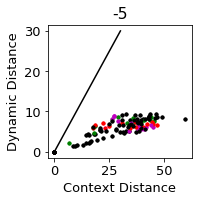

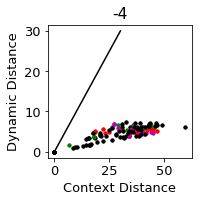

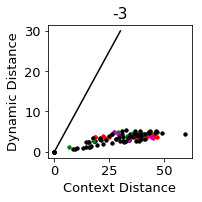

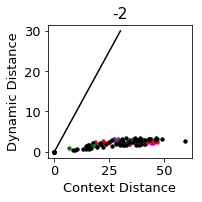

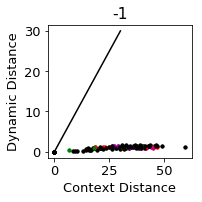

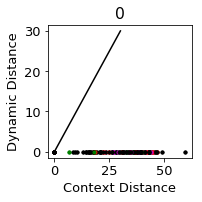

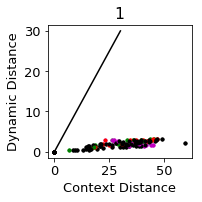

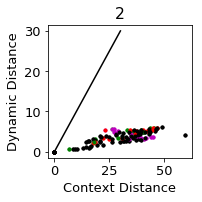

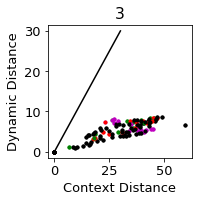

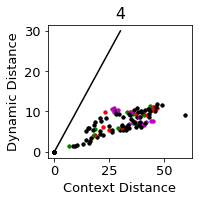

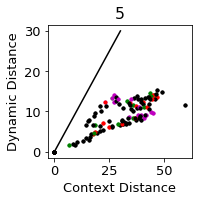

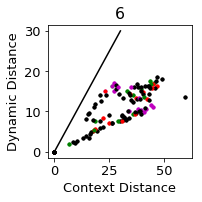

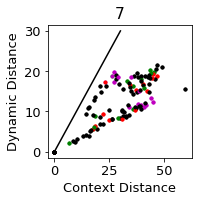

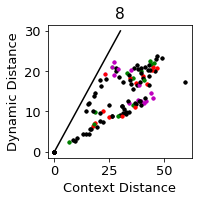

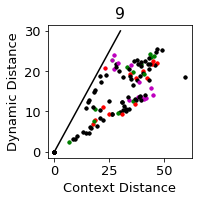

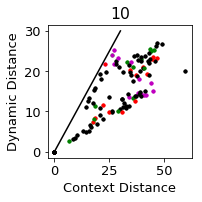

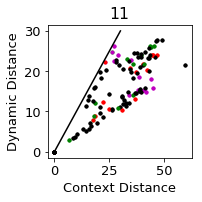

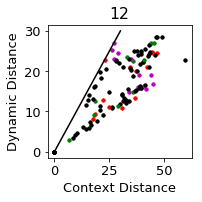

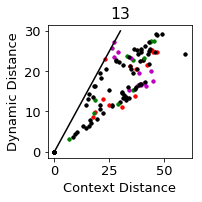

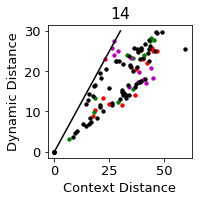

In [10]:
cmap=plt.get_cmap('tab20')

for m in range(np.shape(All_Models_X_euc_dist)[0]):
    X_euc_dist_context = All_Models_X_euc_dist_context[m,:,:,:]
    X_euc_dist = All_Models_X_euc_dist[m,:,:,:]
        
    for t in range(0,np.shape(X_euc_dist)[2]):
        fig = plt.figure(figsize=(3, 3),tight_layout=True,facecolor='white')
        plt.rcParams.update({'font.size': 13})
        for c1 in range(np.shape(X_euc_dist_context)[0]):
            for c2 in range(np.shape(X_euc_dist_context)[0]):
                if c1==1:
                    c_fraction = 'g'
                elif c1==4:
                    c_fraction = 'r'
                elif c1==3:
                    c_fraction = 'm'
    #             elif c1==5:
    #                 c_fraction = 'm'
                elif c2==1:
                    c_fraction = 'g'
                elif c2==4:
                    c_fraction = 'r'
                elif c2==3:
                    c_fraction = 'm'
    #             elif c2==5:
    #                 c_fraction = 'm'
                else:
                    c_fraction = 'k'
    #         c_fraction = cmap(c/np.shape(X_euc_dist_context)[0])
#                 c_fraction = 'k'
                plt.plot(X_euc_dist_context[c1,c2,0].flatten(),X_euc_dist[c1,c2,t].flatten(),'.',c=c_fraction)
        plt.xlabel('Context Distance')
        plt.ylabel('Dynamic Distance')
        plt.title(t-vis_before)
#         plt.title('Relaxation Period')
        plt.plot([0,30],[0,30],'-k')
        plt.show()

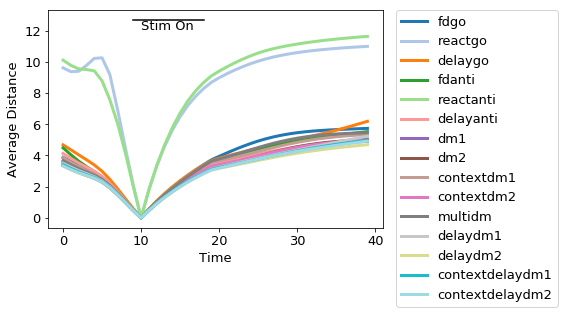

In [68]:
cmap=plt.get_cmap('tab20')
for m in range(np.shape(All_Models_X_euc_dist)[0]):
    X_euc_dist = All_Models_X_euc_dist[m,:,:,:]
    for t in range(np.shape(X_euc_dist)[0]):
        c = cmap(t/14)
        t_compare = range(np.shape(X_euc_dist)[0])
        del t_compare[t]
        ave_dist = np.mean(X_euc_dist[t,t_compare,:],axis = 0)
        plt.plot(ave_dist,'-',c = c,linewidth = .5)
        
X_euc_dist = np.mean(All_Models_X_euc_dist,axis = 0)
for t in range(np.shape(X_euc_dist)[0]):
    c = cmap(t/14)
    t_compare = range(np.shape(X_euc_dist)[0])
    del t_compare[t]
    ave_dist = np.mean(X_euc_dist[t,t_compare,:],axis = 0)
    plt.plot(ave_dist,'-',c = c,label = rule_set[t],linewidth = 3)
        
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
plt.ylabel('Average Distance')
plt.xlabel('Time')
stim_range = range(vis_before-1,vis_before+pulse_size-1)
plt.plot(stim_range,np.max(X_euc_dist)*np.ones(np.shape(stim_range)),'k')
plt.text(vis_before,.95*np.max(X_euc_dist),'Stim On')
plt.show()

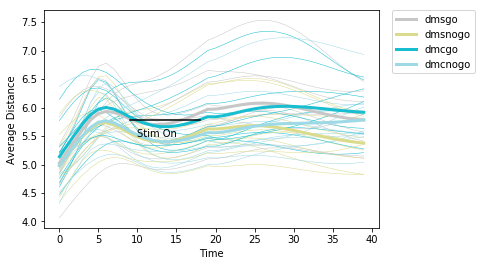

In [174]:
cmap=plt.get_cmap('tab20')
for m in range(np.shape(All_Models_X_euc_dist)[0]):
    X_euc_dist = All_Models_X_euc_dist[m,:,:,:]
    for t in range(11,15):
        c = cmap(t/14)
        t_compare = range(np.shape(X_euc_dist)[0])
        del t_compare[t]
        ave_dist = np.mean(X_euc_dist[t,t_compare,:],axis = 0)
        plt.plot(ave_dist,'-',c = c,linewidth = .5)
        
X_euc_dist = np.mean(All_Models_X_euc_dist,axis = 0)
for t in range(11,15):
    c = cmap(t/14)
    t_compare = range(np.shape(X_euc_dist)[0])
    del t_compare[t]
    ave_dist = np.mean(X_euc_dist[t,t_compare,:],axis = 0)
    plt.plot(ave_dist,'-',c = c,label = rule_set[t],linewidth = 3)
        
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
plt.ylabel('Average Distance')
plt.xlabel('Time')
stim_range = range(vis_before-1,vis_before+pulse_size-1)
plt.plot(stim_range,np.max(ave_dist)*np.ones(np.shape(stim_range)),'k')
plt.text(vis_before,.95*np.max(ave_dist),'Stim On')
plt.show()

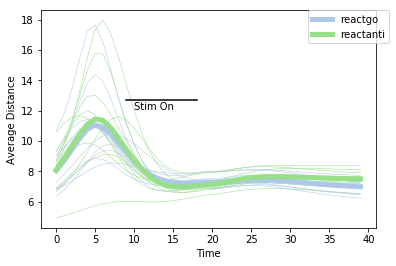

In [164]:
cmap=plt.get_cmap('tab20')
for m in range(np.shape(All_Models_X_euc_dist)[0]):
    X_euc_dist = All_Models_X_euc_dist[m,:,:,:]
    for t in [1, 4]:
        c = cmap(t/14)
        t_compare = range(np.shape(X_euc_dist)[0])
        del t_compare[t]
        ave_dist = np.mean(X_euc_dist[t,t_compare,:],axis = 0)
        plt.plot(ave_dist,'-',c = c,linewidth = .5)
        
X_euc_dist = np.mean(All_Models_X_euc_dist,axis = 0)
for t in [1, 4]:
    c = cmap(t/14)
    t_compare = range(np.shape(X_euc_dist)[0])
    del t_compare[t]
    ave_dist = np.mean(X_euc_dist[t,t_compare,:],axis = 0)
    plt.plot(ave_dist,'-',c = c,label = rule_set[t],linewidth = 5)
        
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
plt.ylabel('Average Distance')
plt.xlabel('Time')
stim_range = range(vis_before-1,vis_before+pulse_size-1)
plt.plot(stim_range,np.max(X_euc_dist)*np.ones(np.shape(stim_range)),'k')
plt.text(vis_before,.95*np.max(X_euc_dist),'Stim On')
plt.show()


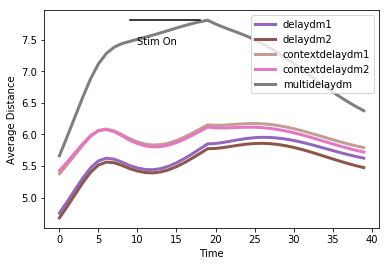

In [177]:
compare_set = range(6,11)
for t in compare_set:
    c = cmap(t/14)
    t_compare = range(np.shape(X_euc_dist)[0]) #compare_set#
    t_compare.remove(t)
    ave_dist = np.mean(X_euc_dist[t,t_compare,:],axis = 0)
    plt.plot(ave_dist,'-',c = c,label = rule_set[t],linewidth = 3)
plt.legend()
plt.ylabel('Average Distance')
plt.xlabel('Time')
stim_range = range(vis_before-1,vis_before+pulse_size-1)
plt.plot(stim_range,np.max(ave_dist)*np.ones(np.shape(stim_range)),'k')
plt.text(vis_before,.95*np.max(ave_dist),'Stim On')
plt.show()

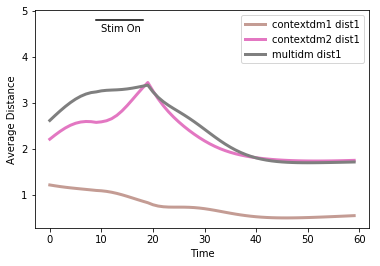

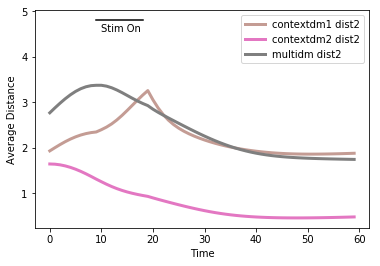

In [139]:
compare_set = range(8,11)
for t in compare_set:
    c = cmap(t/14)
    t_compare = [6]
    if t in t_compare:
        t_compare.remove(t)
    ave_dist1 = np.mean(X_euc_dist[t,t_compare,:],axis = 0)
#     ave_dist2 = np.mean(X_euc_dist[t,[7,9],:],axis = 0)
    plt.plot(ave_dist1,'-',c = c,label = rule_set[t]+ ' dist1',linewidth = 3)
#     plt.plot(ave_dist2,':',c = c,label = rule_set[t]+ ' dist2')
plt.legend()
plt.ylabel('Average Distance')
plt.xlabel('Time')
stim_range = range(vis_before-1,vis_before+pulse_size-1)
plt.plot(stim_range,np.max(ave_dist)*np.ones(np.shape(stim_range)),'k')
plt.text(vis_before,.95*np.max(ave_dist),'Stim On')
plt.show()

compare_set = range(8,11)
for t in compare_set:
    c = cmap(t/14)
    t_compare = [7]
    if t in t_compare:
        t_compare.remove(t)
    ave_dist1 = np.mean(X_euc_dist[t,t_compare,:],axis = 0)
#     ave_dist2 = np.mean(X_euc_dist[t,[7,9],:],axis = 0)
    plt.plot(ave_dist1,'-',c = c,label = rule_set[t]+ ' dist2',linewidth = 3)
#     plt.plot(ave_dist2,':',c = c,label = rule_set[t]+ ' dist2')
plt.legend()
plt.ylabel('Average Distance')
plt.xlabel('Time')
stim_range = range(vis_before-1,vis_before+pulse_size-1)
plt.plot(stim_range,np.max(ave_dist)*np.ones(np.shape(stim_range)),'k')
plt.text(vis_before,.95*np.max(ave_dist),'Stim On')
plt.show()

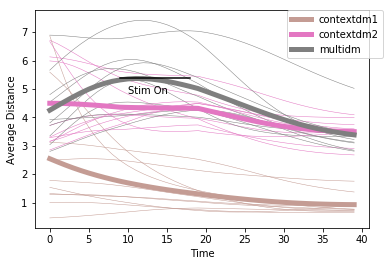

In [163]:
cmap=plt.get_cmap('tab20')
for m in range(np.shape(All_Models_X_euc_dist)[0]):
    X_euc_dist = All_Models_X_euc_dist[m,:,:,:]
    for t in range(8,11):
        c = cmap(t/14)
        t_compare = [6]
        ave_dist = np.mean(X_euc_dist[t,t_compare,:],axis = 0)
        plt.plot(ave_dist,'-',c = c,linewidth = .5)
        
X_euc_dist = np.mean(All_Models_X_euc_dist,axis = 0)
for t in range(8,11):
    c = cmap(t/14)
    t_compare = [6]
    ave_dist = np.mean(X_euc_dist[t,t_compare,:],axis = 0)
    plt.plot(ave_dist,'-',c = c,label = rule_set[t],linewidth = 5)
        
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
plt.ylabel('Average Distance')
plt.xlabel('Time')
stim_range = range(vis_before-1,vis_before+pulse_size-1)
plt.plot(stim_range,np.max(ave_dist)*np.ones(np.shape(stim_range)),'k')
plt.text(vis_before,.9*np.max(ave_dist),'Stim On')
plt.show()

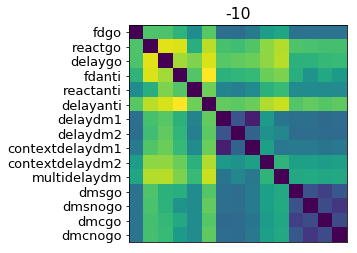

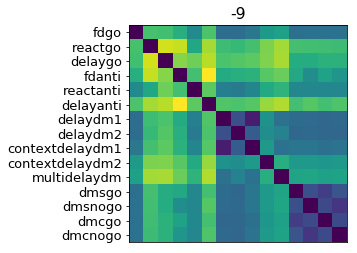

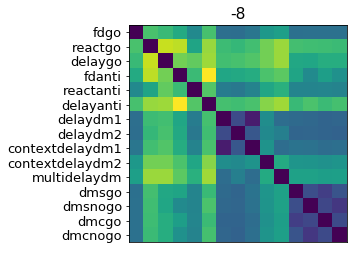

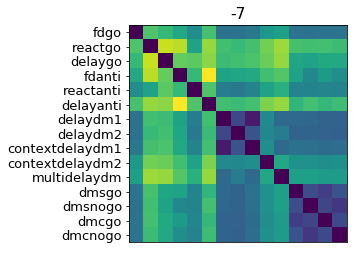

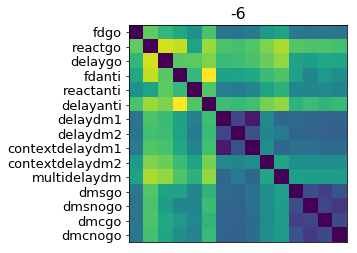

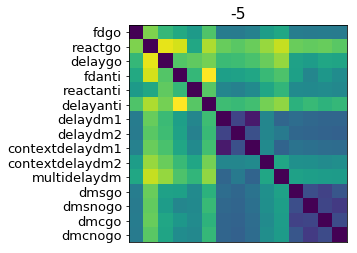

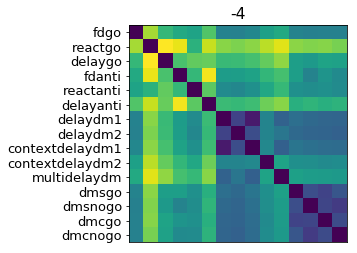

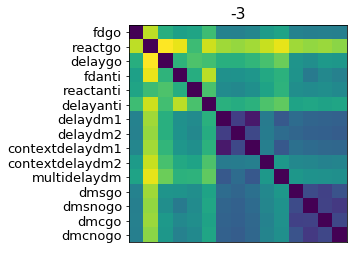

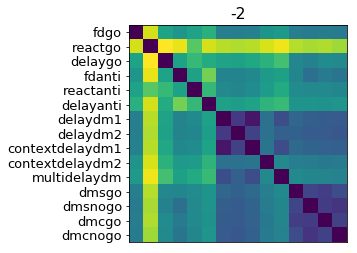

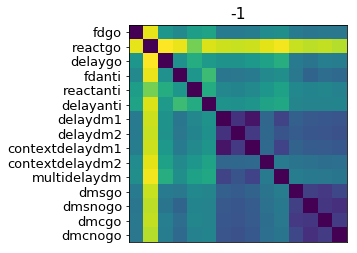

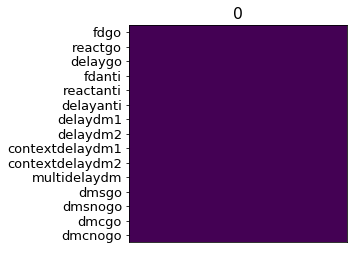

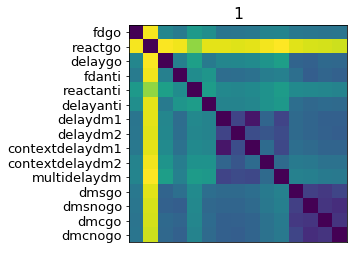

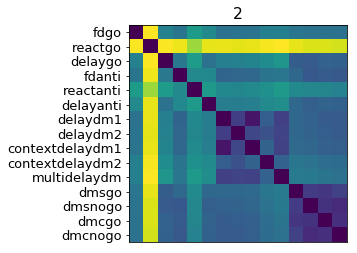

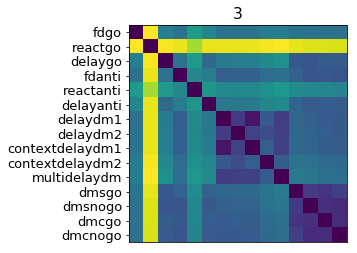

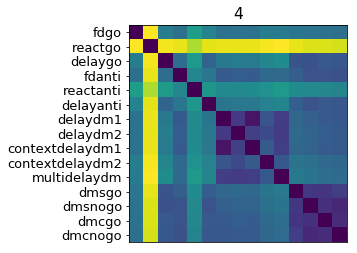

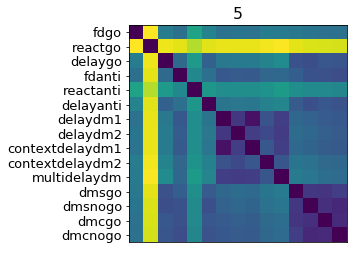

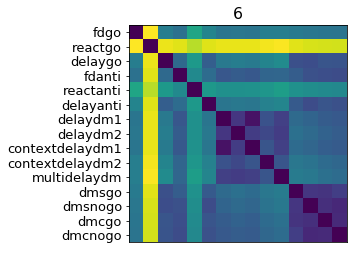

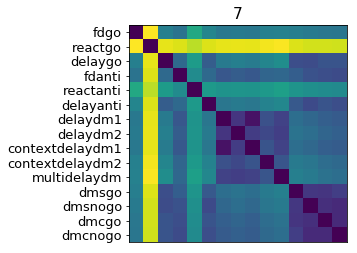

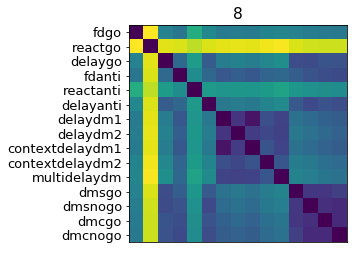

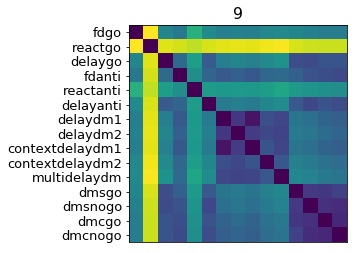

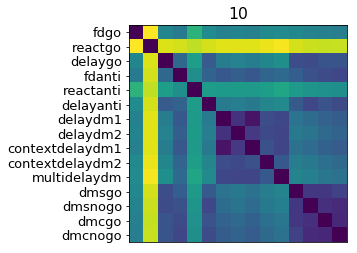

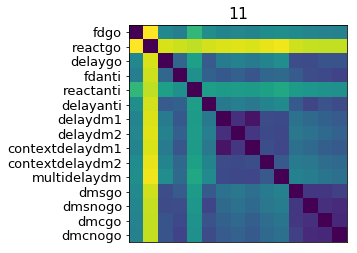

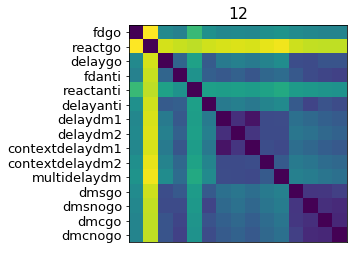

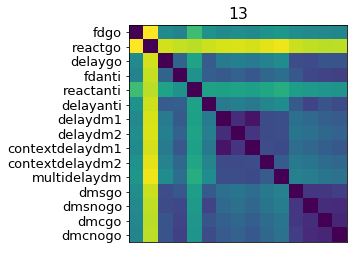

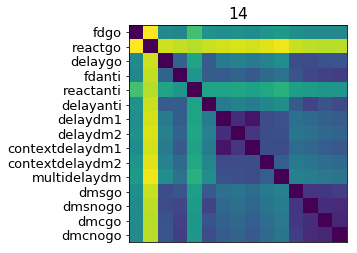

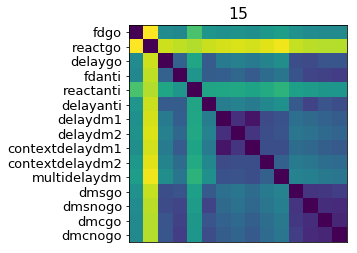

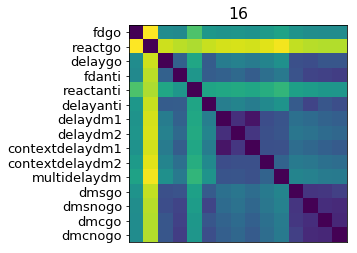

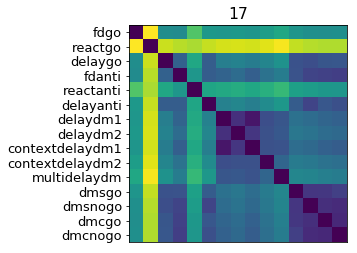

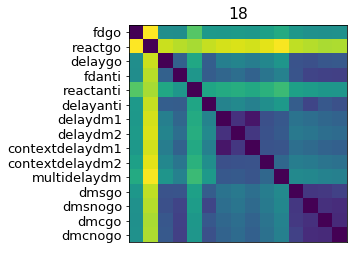

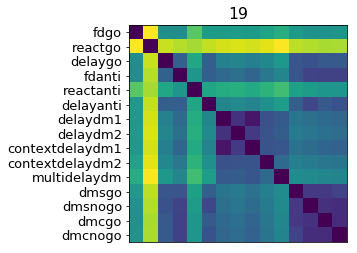

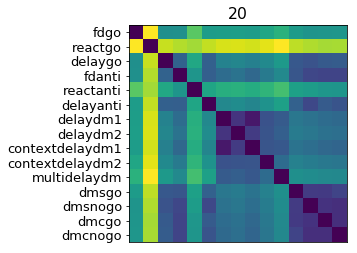

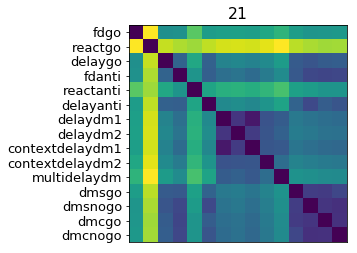

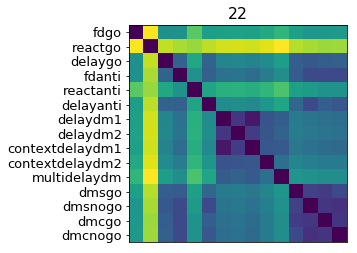

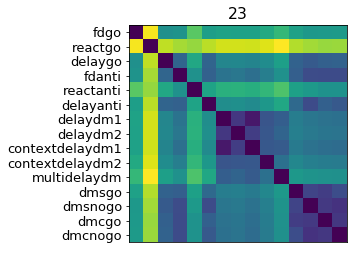

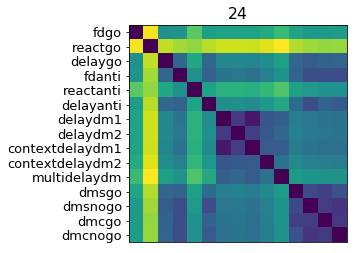

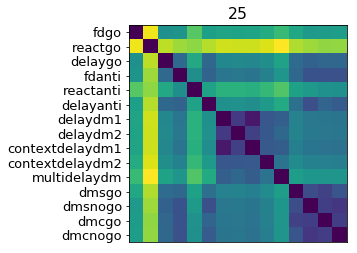

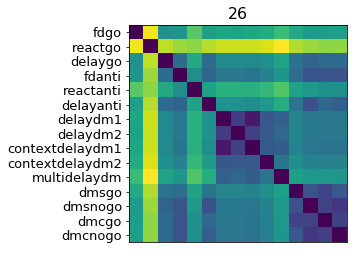

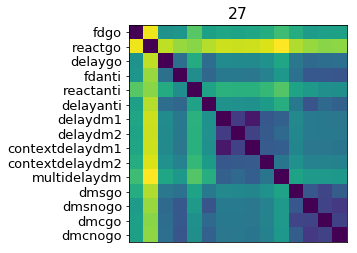

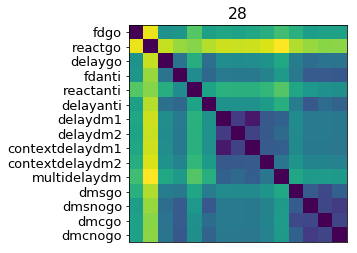

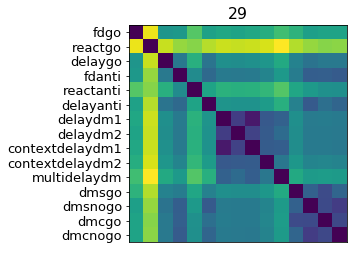

In [77]:
for h_ind in range(np.shape(X_euc_dist)[2]):
    plt.imshow(X_euc_dist[:,:,h_ind])
    plt.title(h_ind-vis_before)
    plt.yticks(np.arange(len(rule_set)), rule_set)
    plt.xticks([])
    plt.show()

In [11]:
for h_ind in range(np.shape(h_pulse_combined)[1]):

    X = h_pulse_combined[:,h_ind,:].astype(np.float64)
    row_means = np.mean(X, axis=0)
    X_center = X - np.tile(row_means,(X.shape[0],1))
    
    embedding = MDS(n_components=2)
    X_transformed = embedding.fit_transform(X_center)
    
    if h_ind is vis_before:
        Xr_ss = X_transformed
    else:
        v1 = np.array([1,0])
        v2 = X_transformed[0,:]
        theta = angle_between(v1, v2)
        if X_transformed[0,1]>0:
            theta = -theta
        R = rot_mat(theta)
        Xr_ss = tranform_in_rPC(X_transformed,R,X_transformed)

    fig = plt.figure(figsize=(7, 7),tight_layout=True,facecolor='white')
    plt.rcParams.update({'font.size': 16})
    ax = plt.plot(Xr_ss[:,0],Xr_ss[:,1],'o')
    for r in range(len(rule_n)):
#         r = 4
        rule = rule_set_names[rule_n[r]]
        plt.text(Xr_ss[r,0]*1.01,Xr_ss[r,1]*1.01,rule)
    plt.title(h_ind-vis_before)
    plt.box(False)
    plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
    plt.show()

NameError: name 'angle_between' is not defined

/Users/lauradriscoll/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


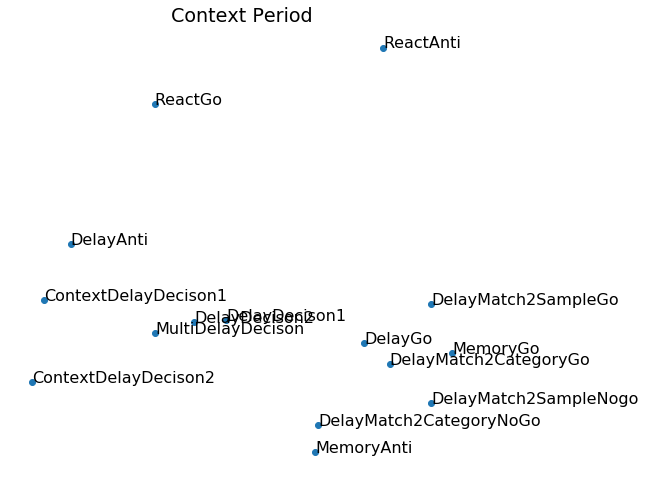

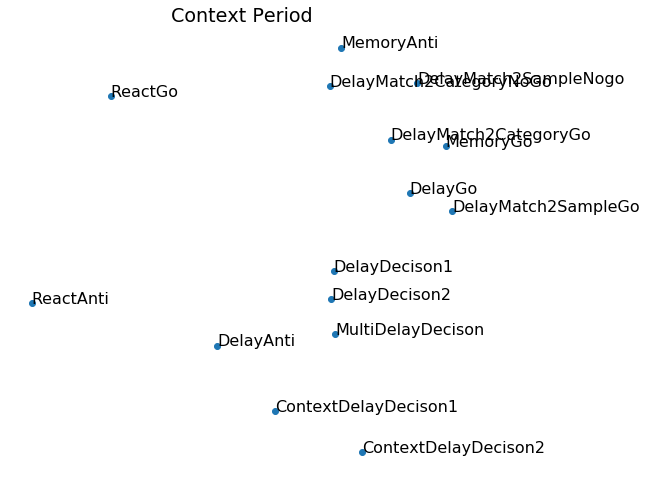

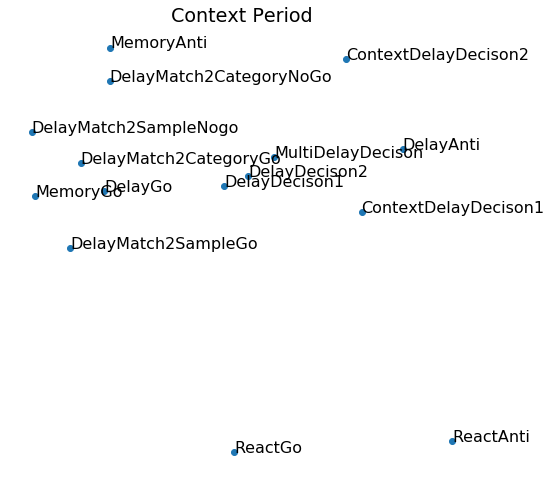

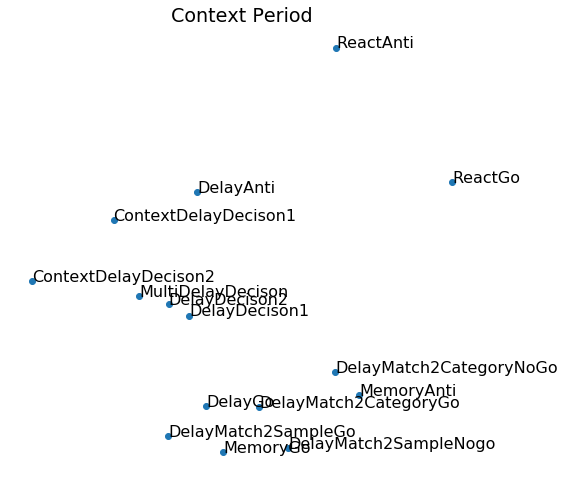

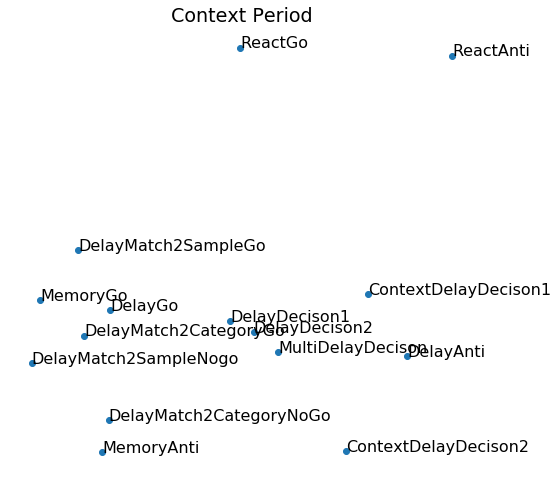

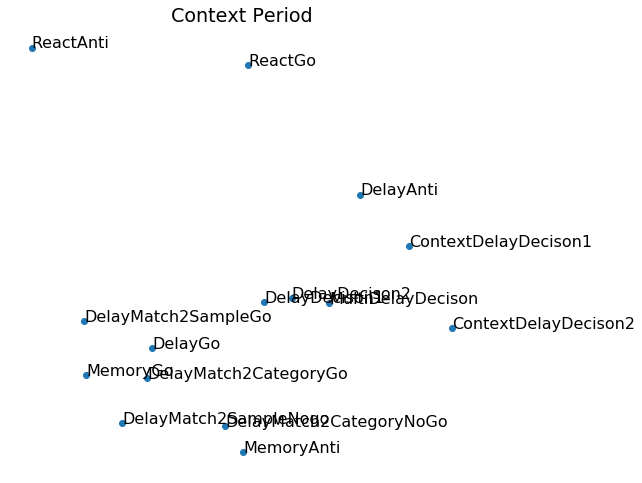

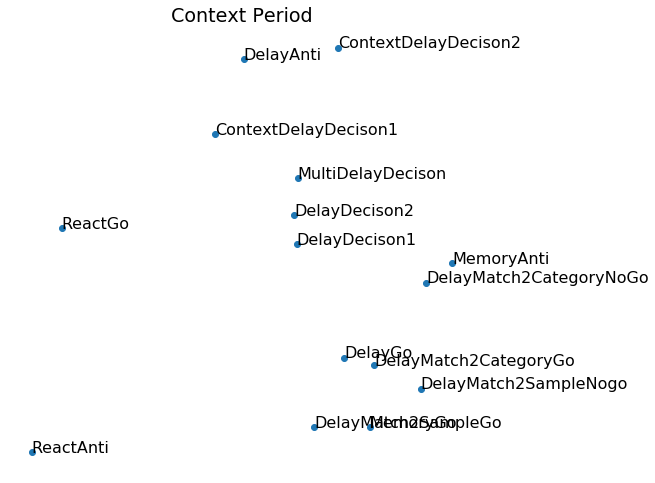

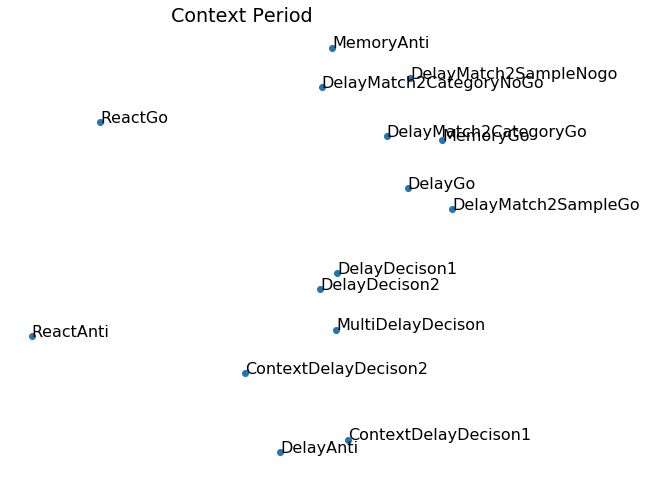

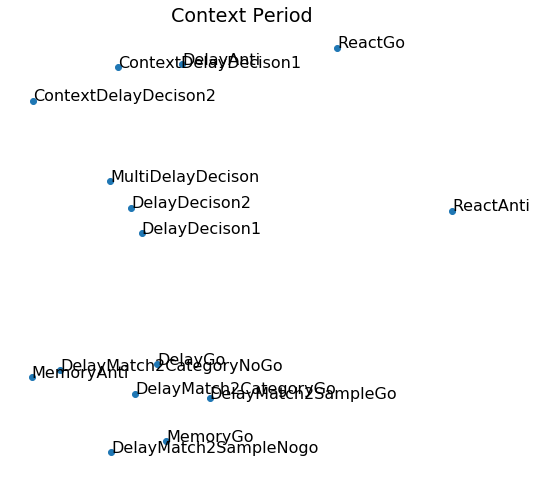

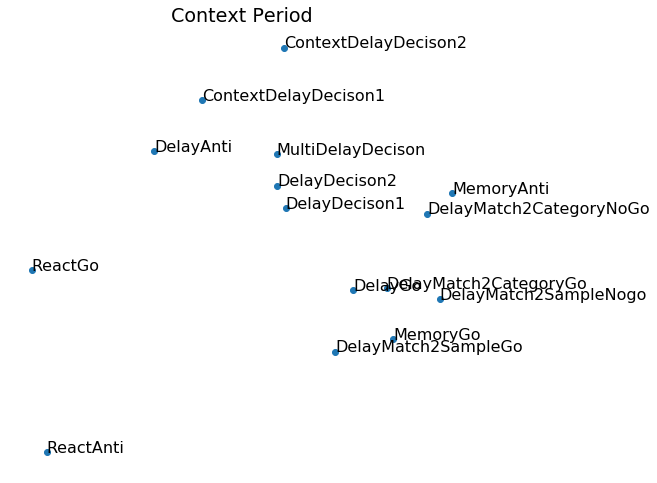

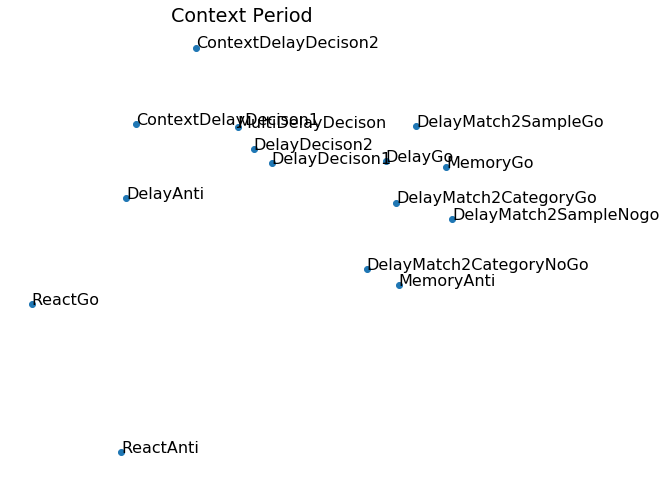

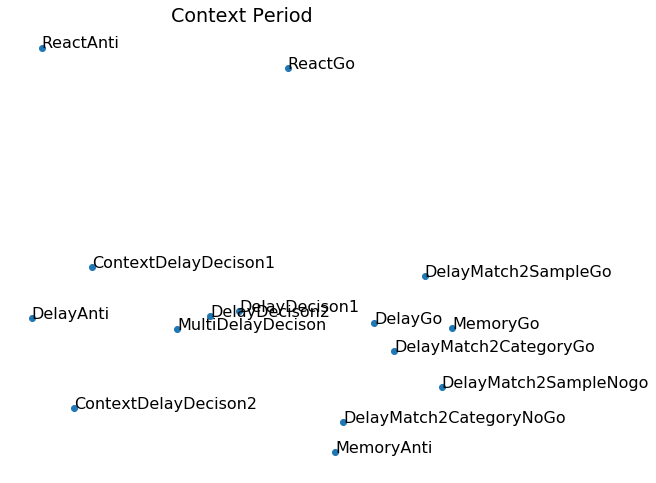

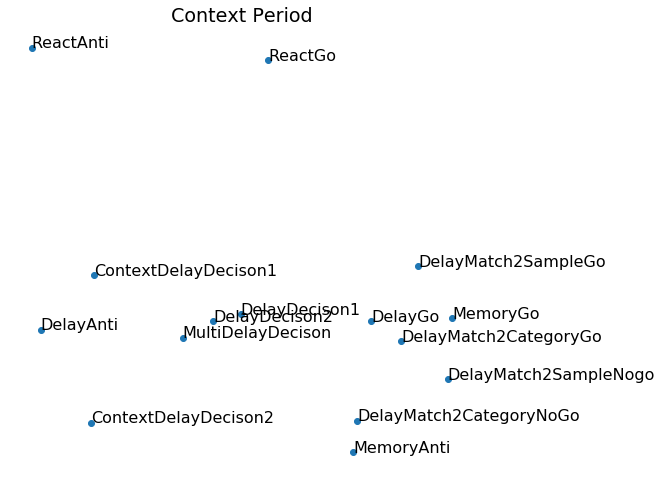

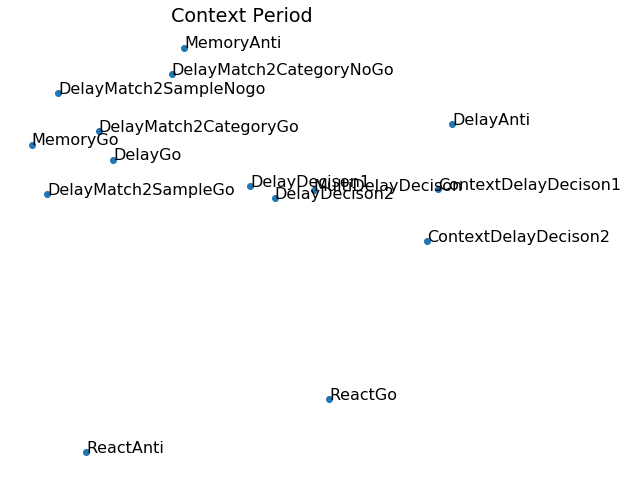

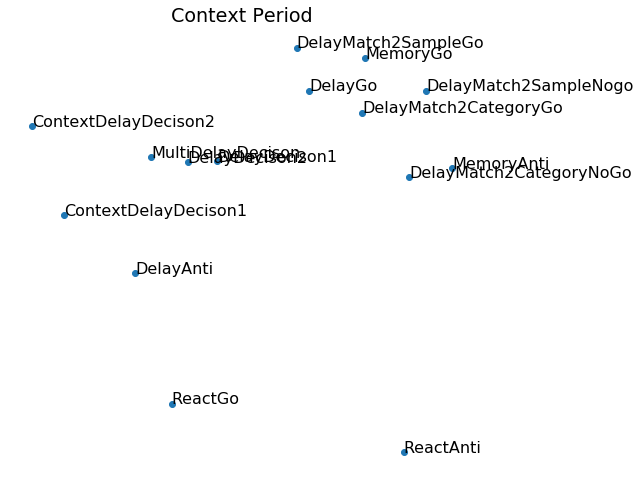

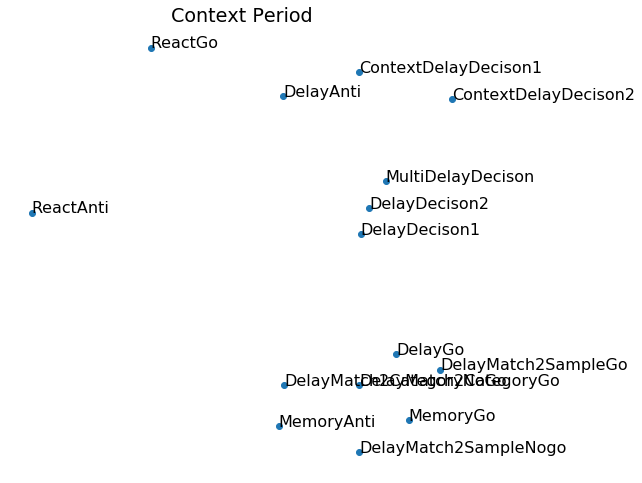

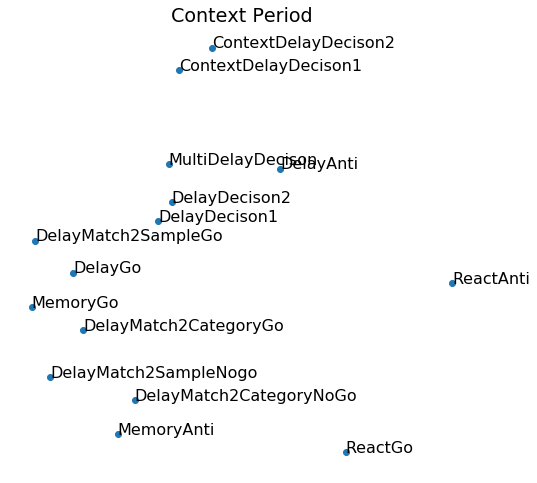

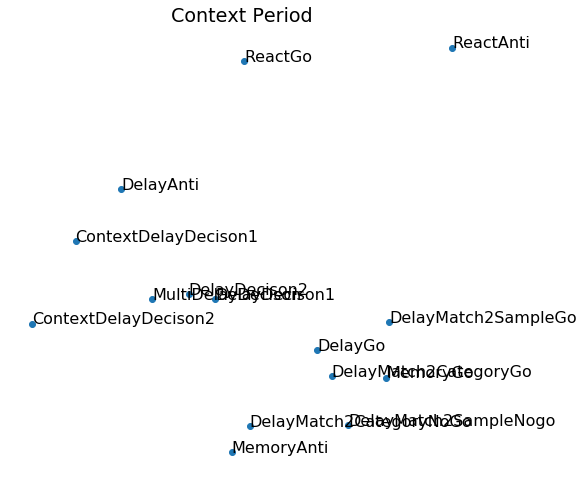

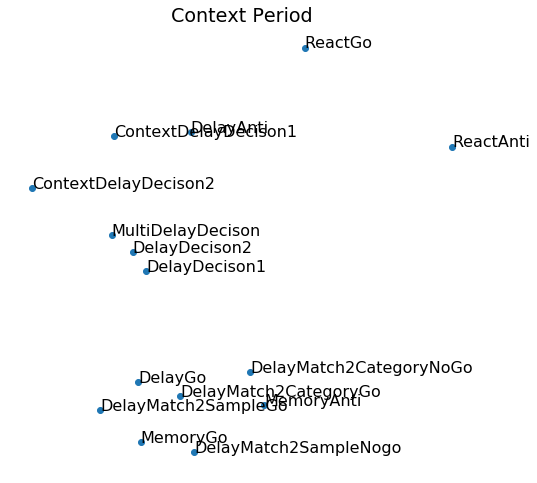

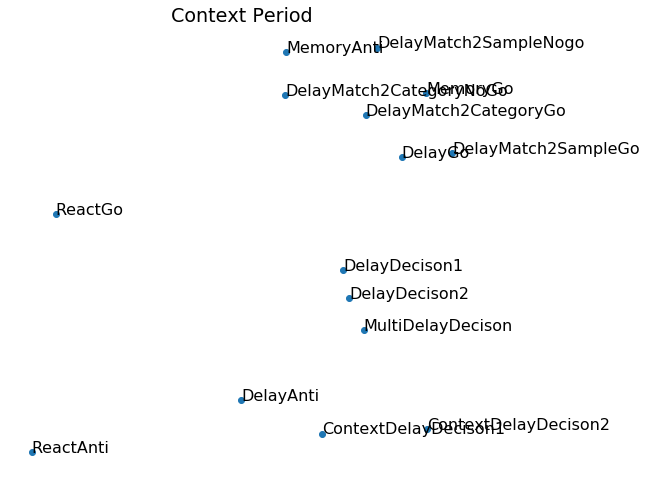

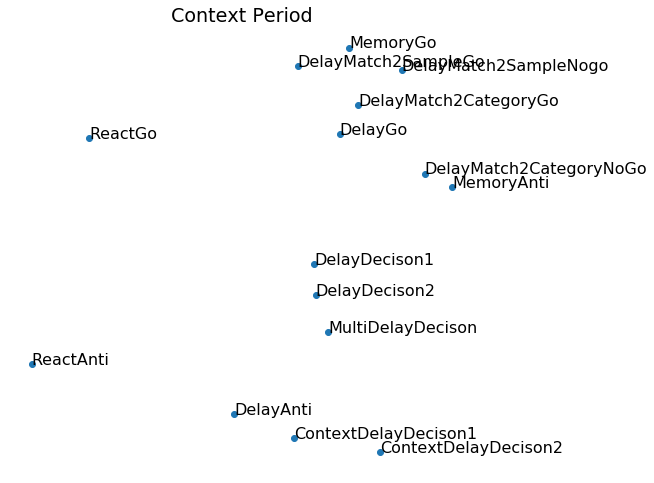

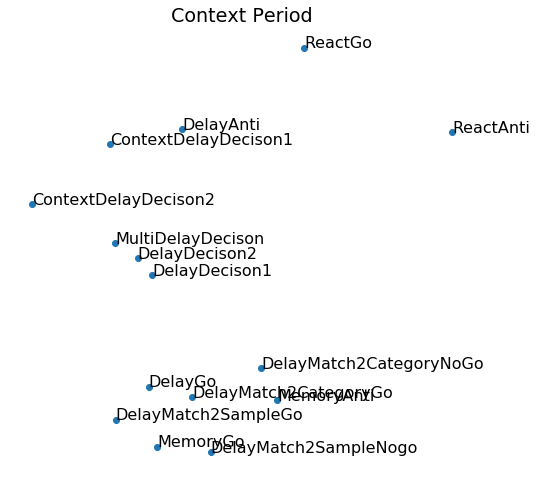

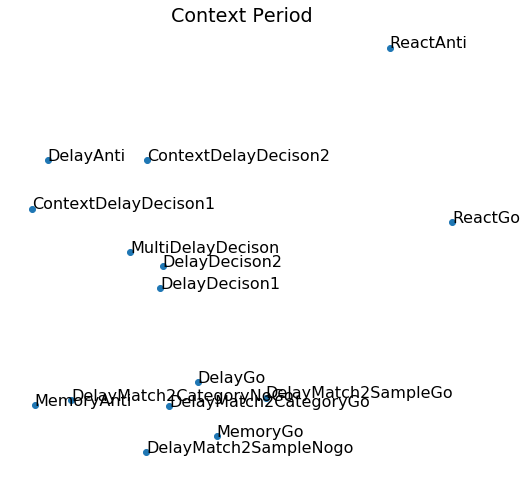

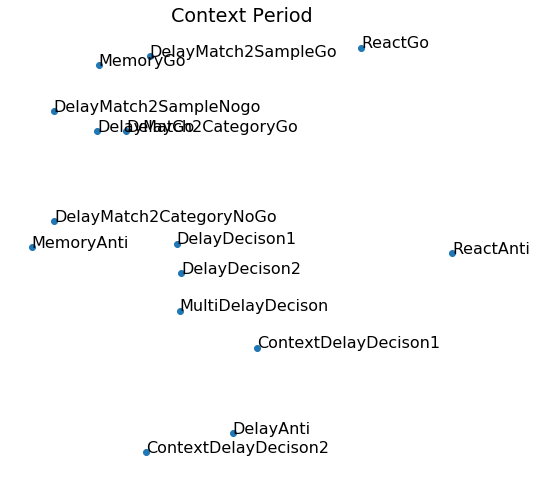

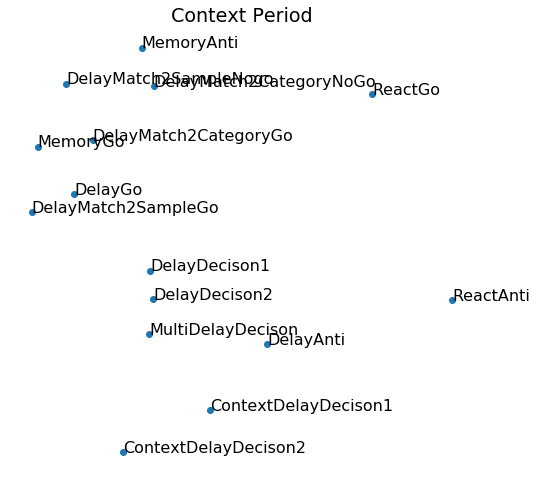

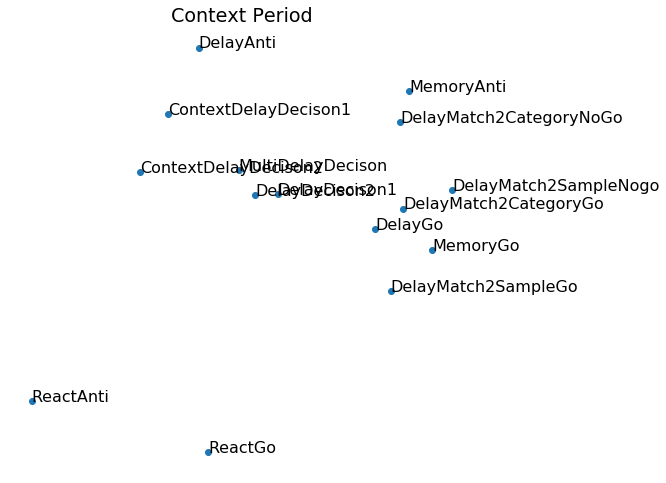

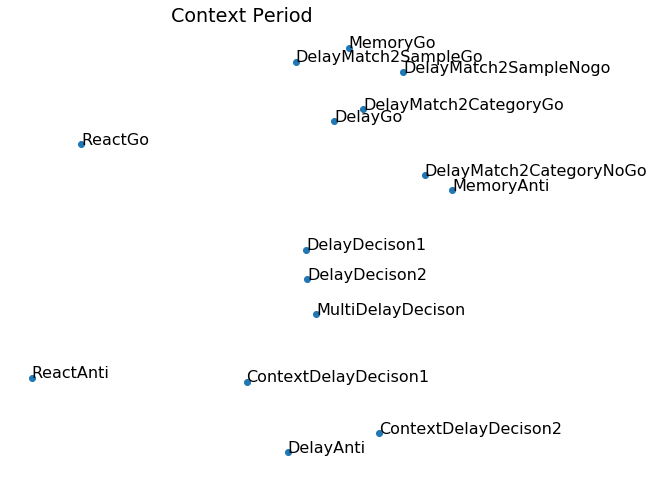

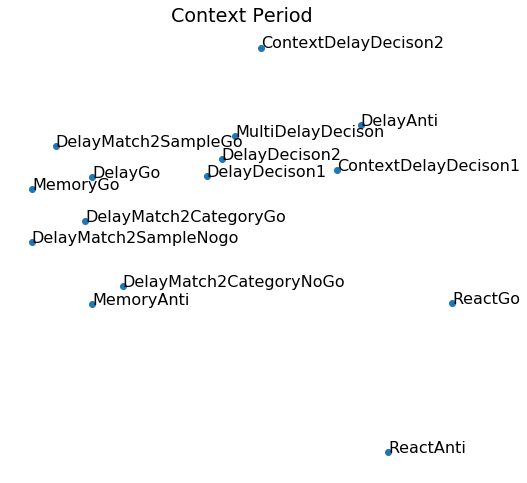

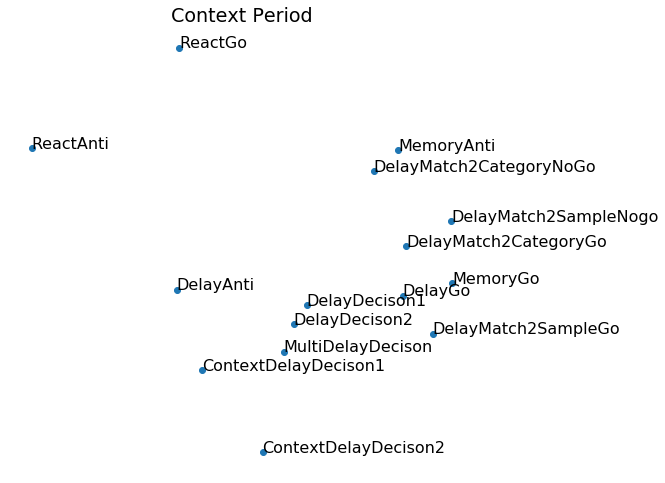

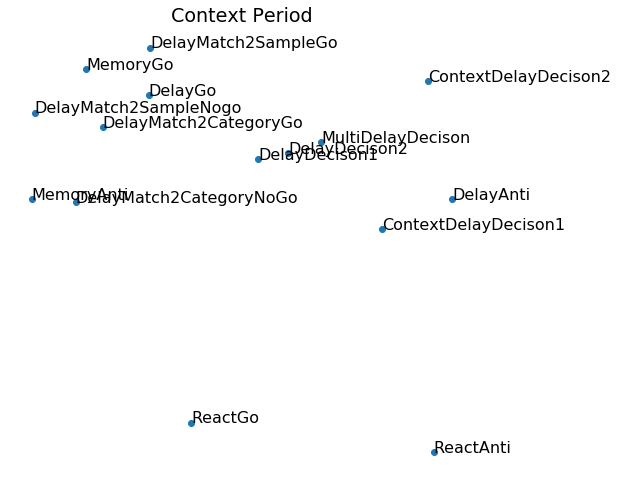

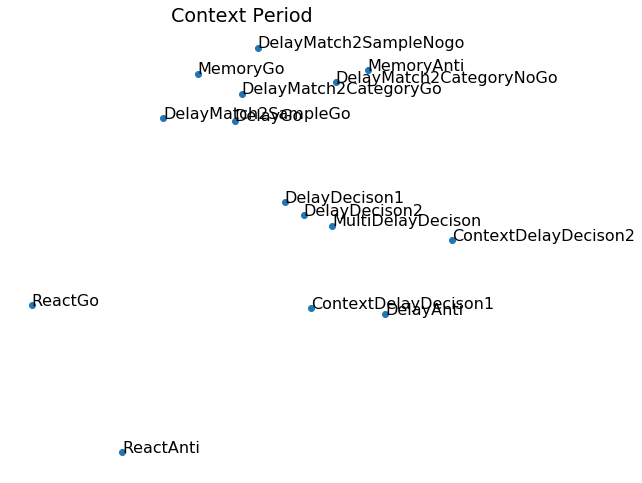

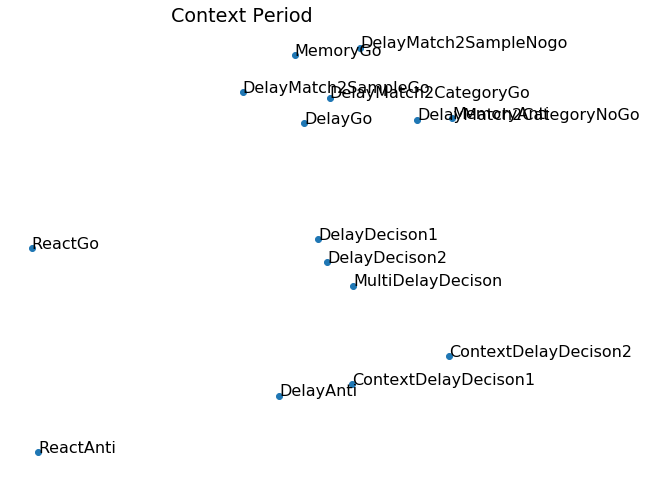

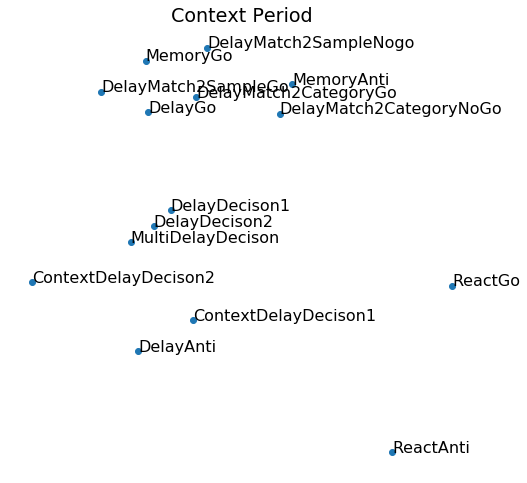

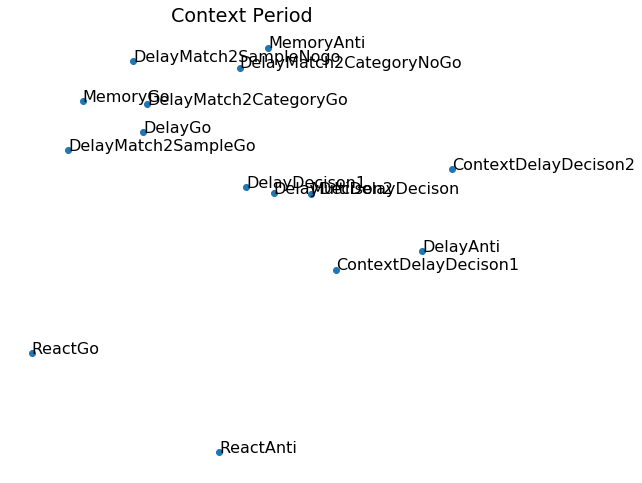

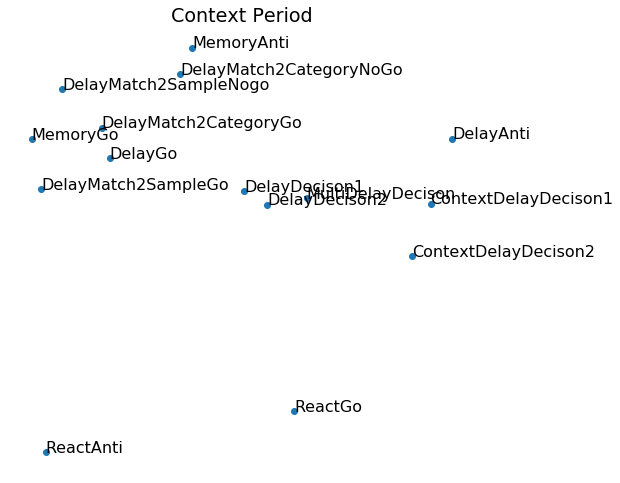

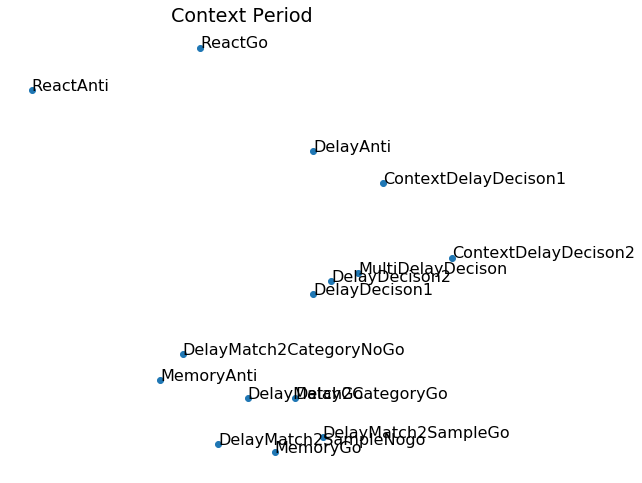

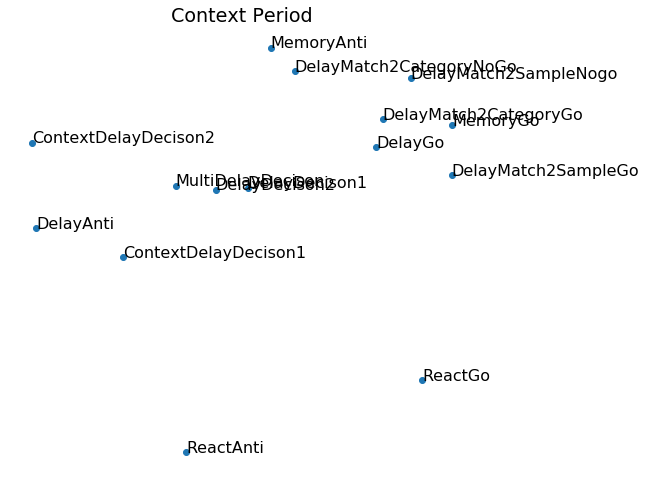

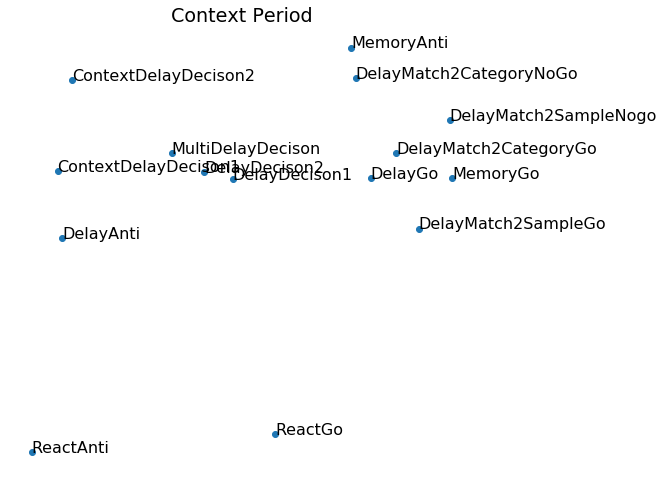

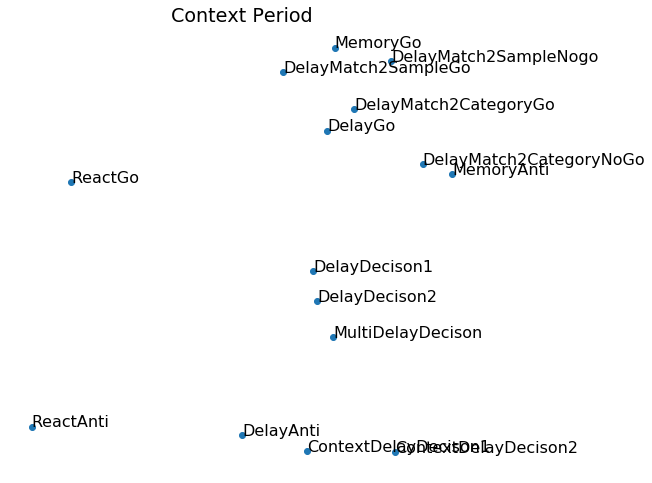

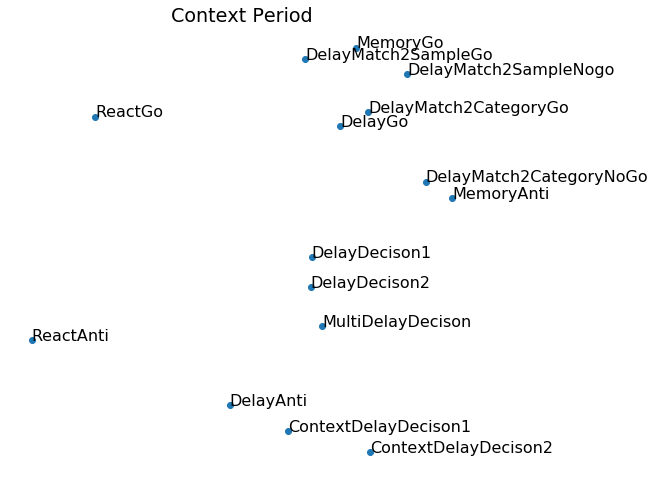

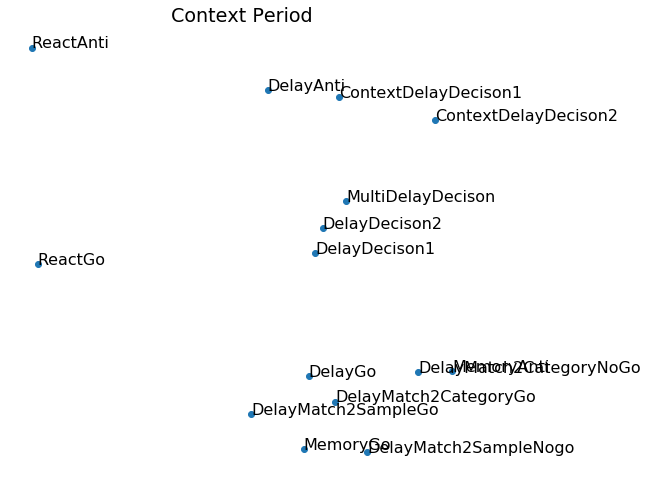

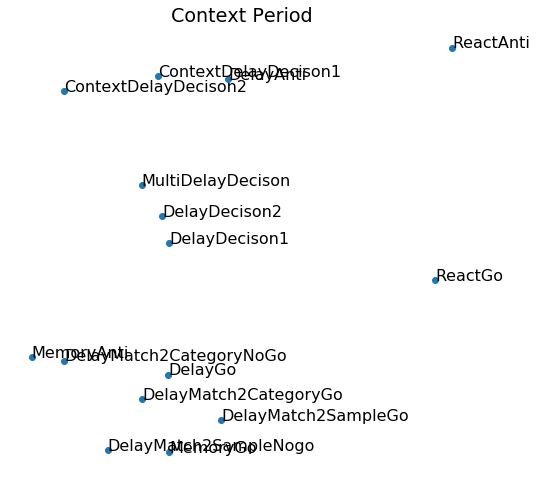

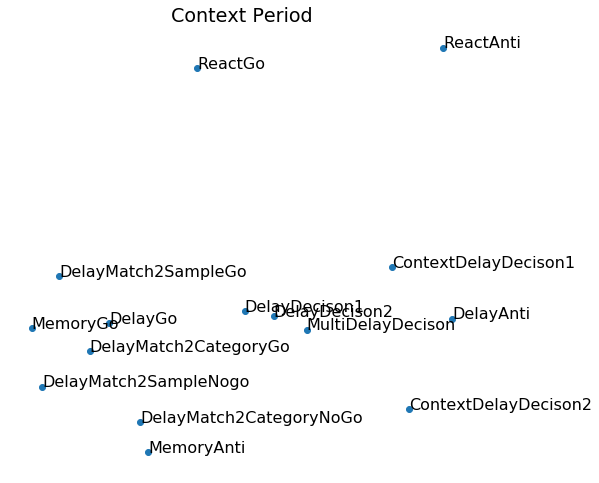

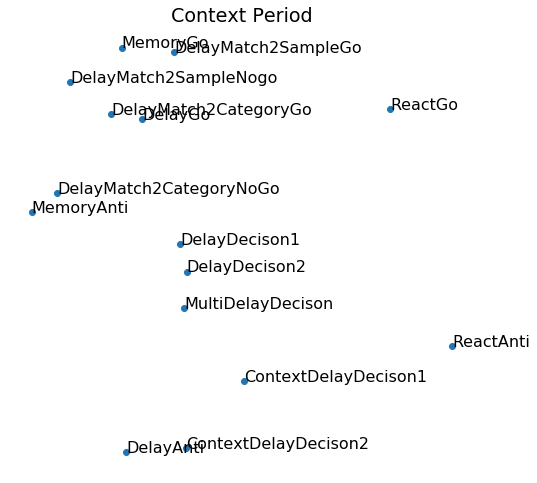

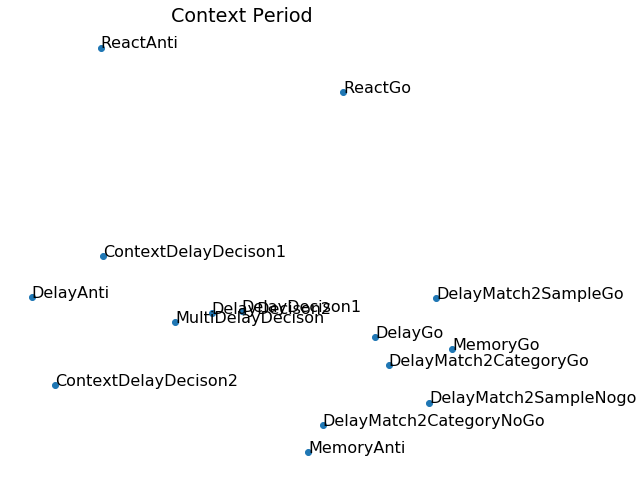

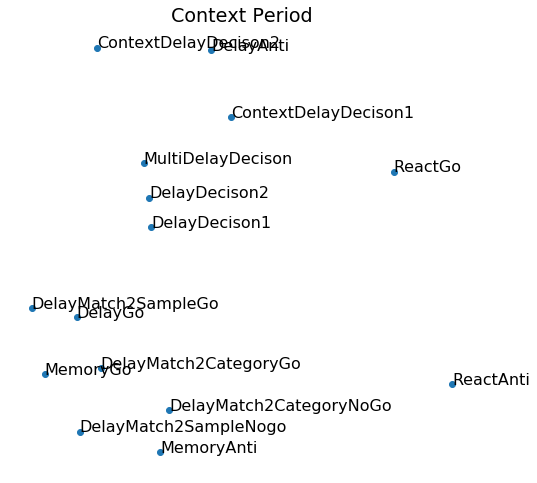

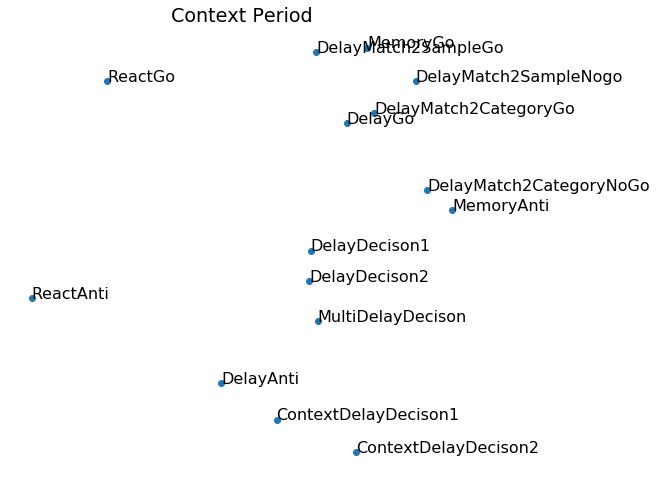

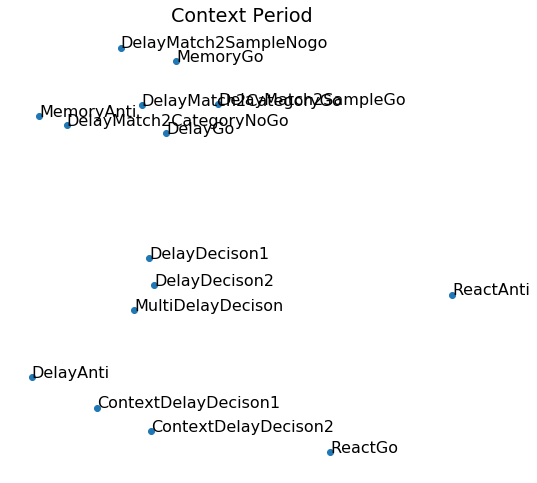

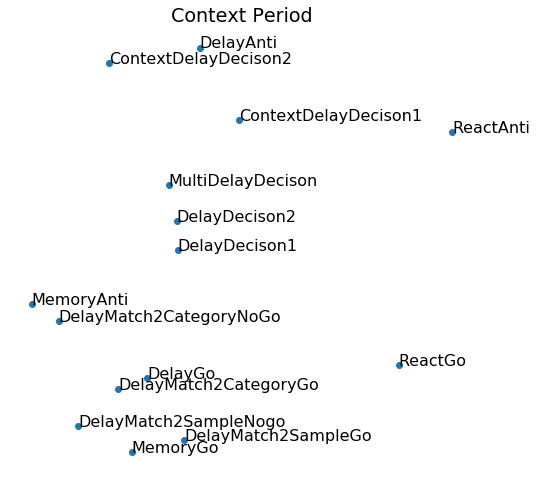

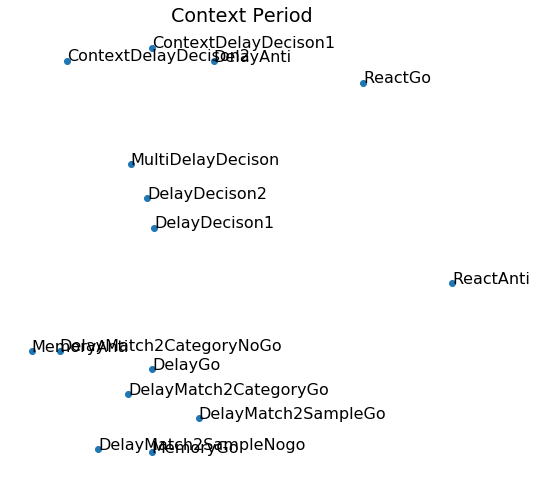

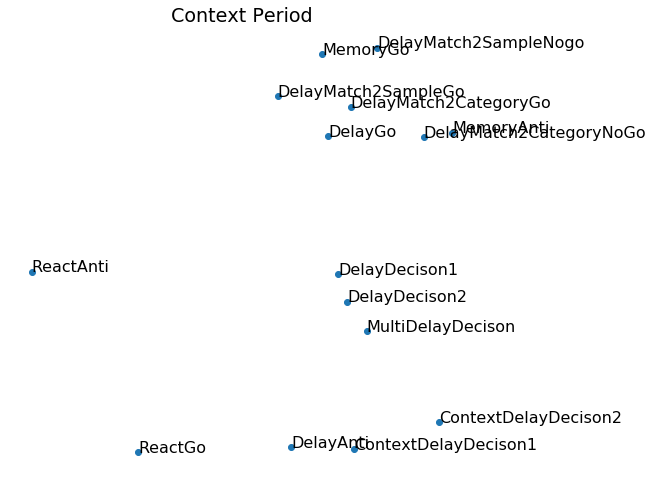

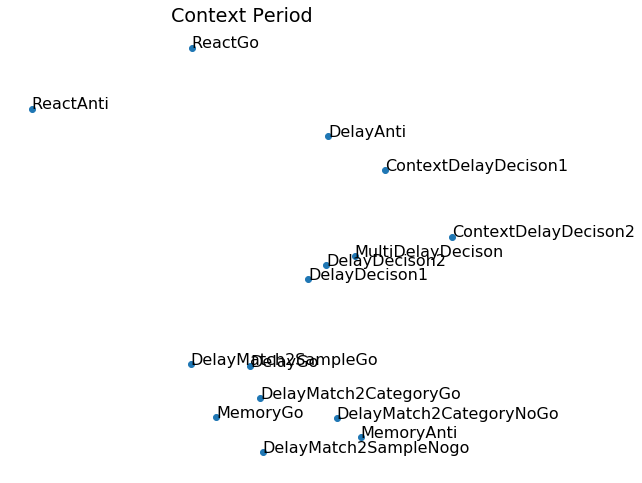

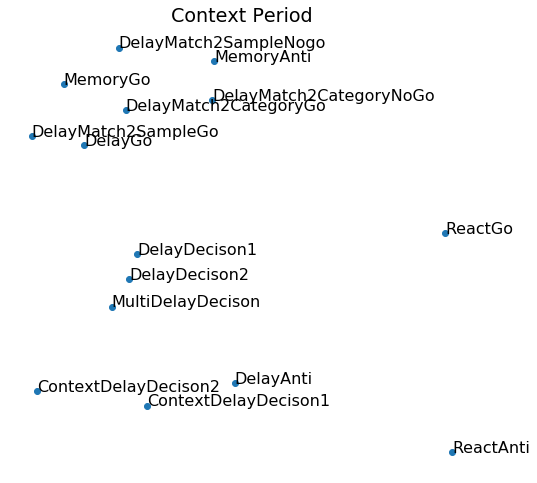

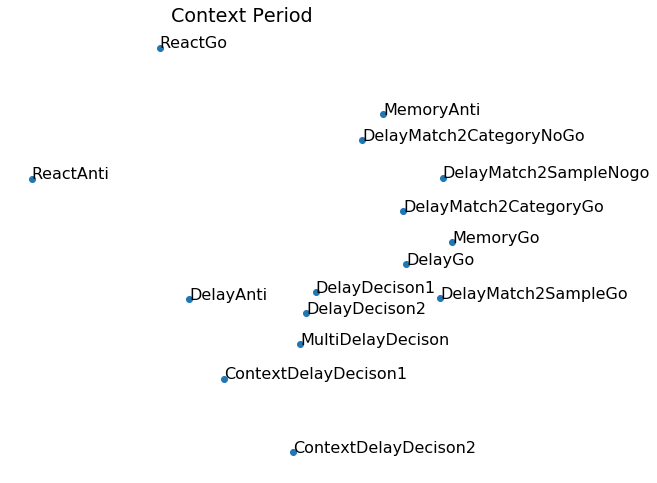

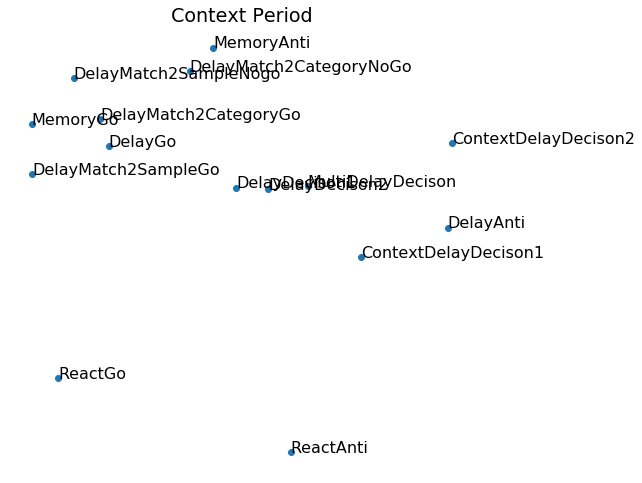

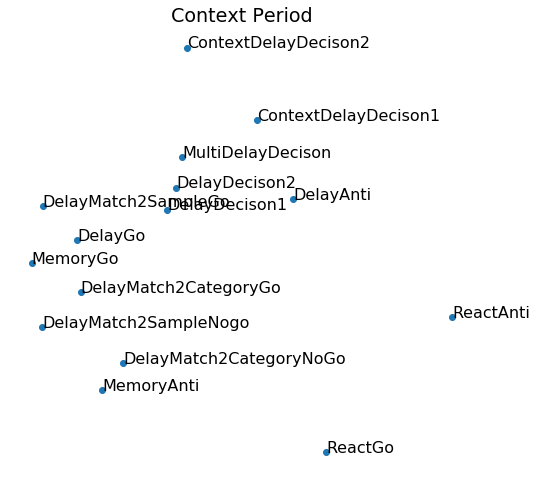

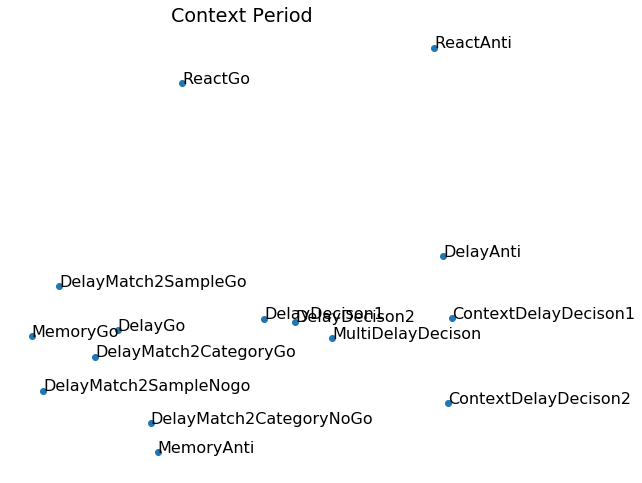

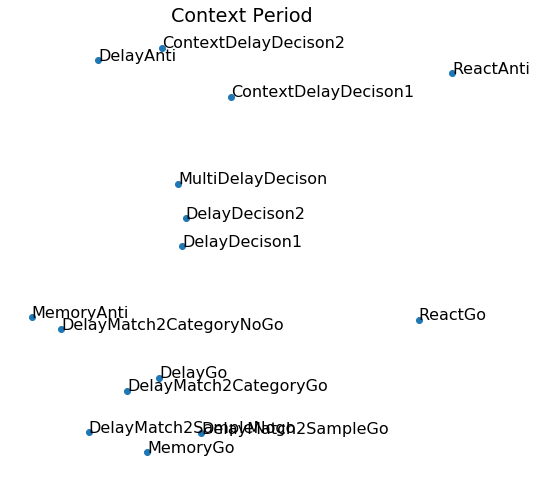

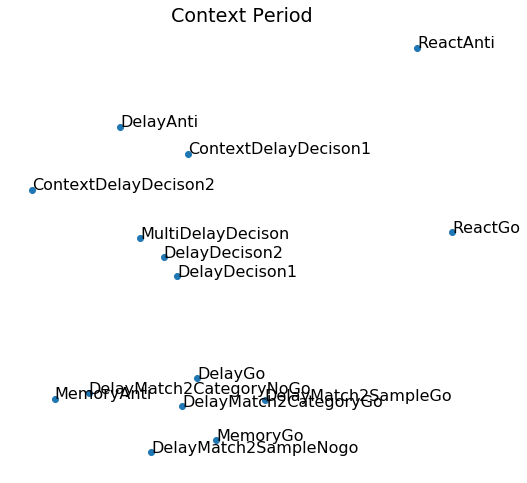

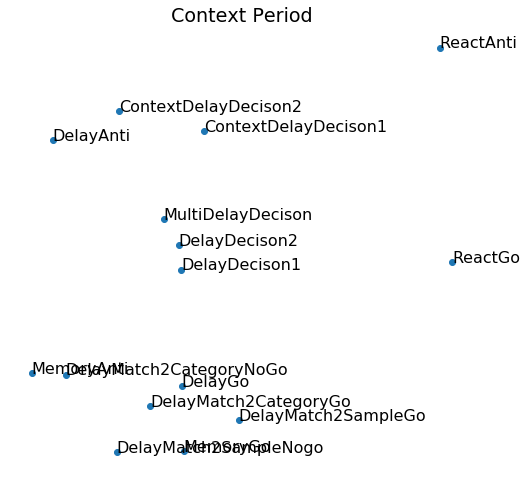

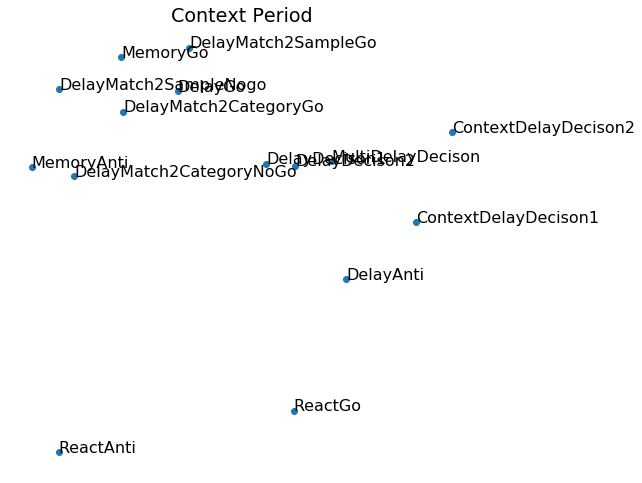

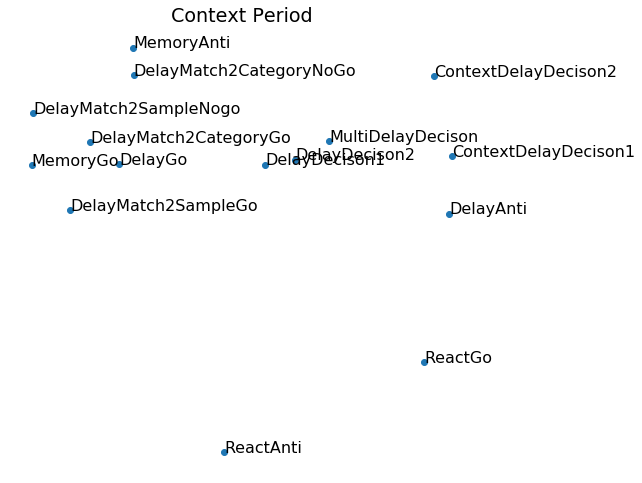

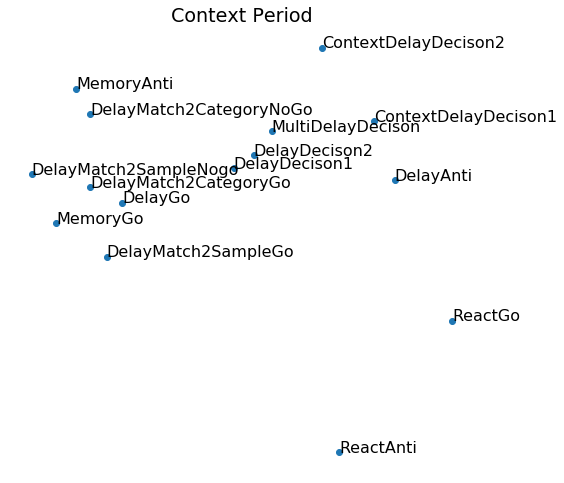

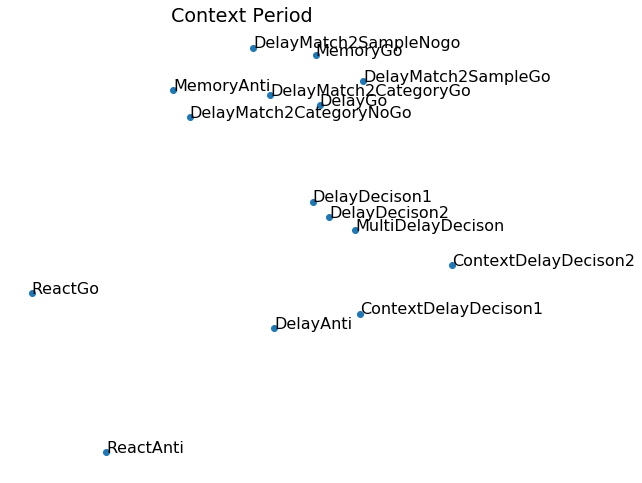

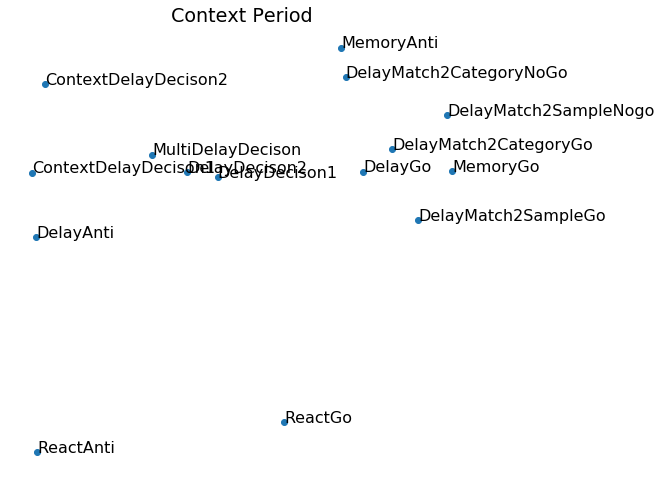

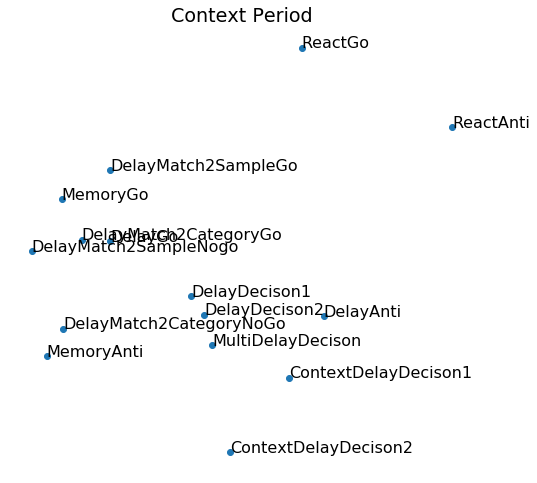

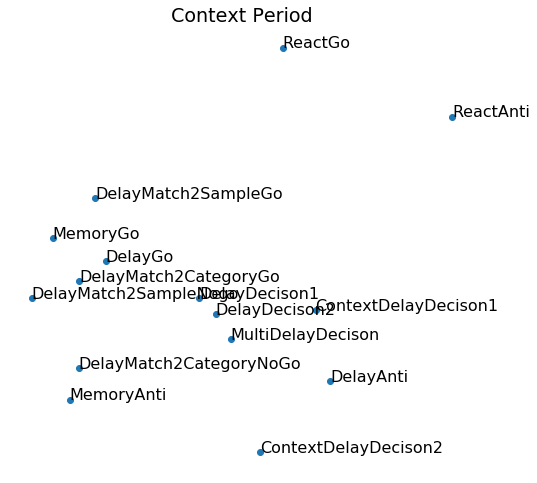

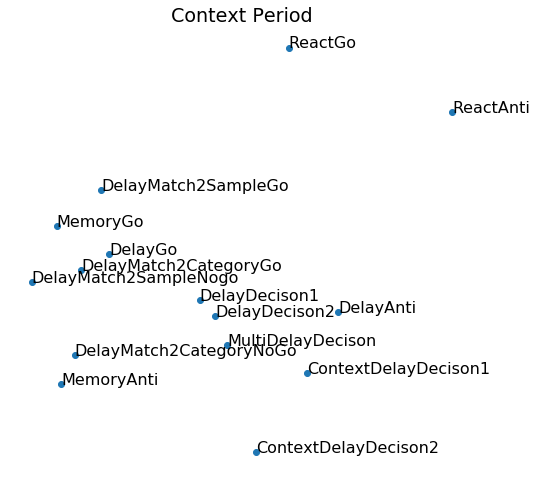

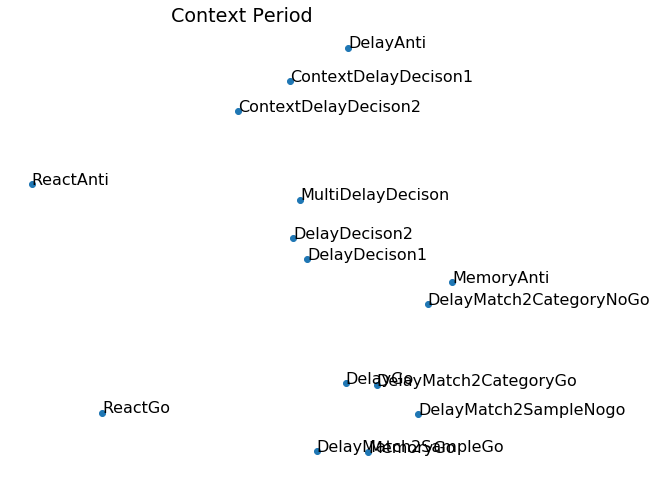

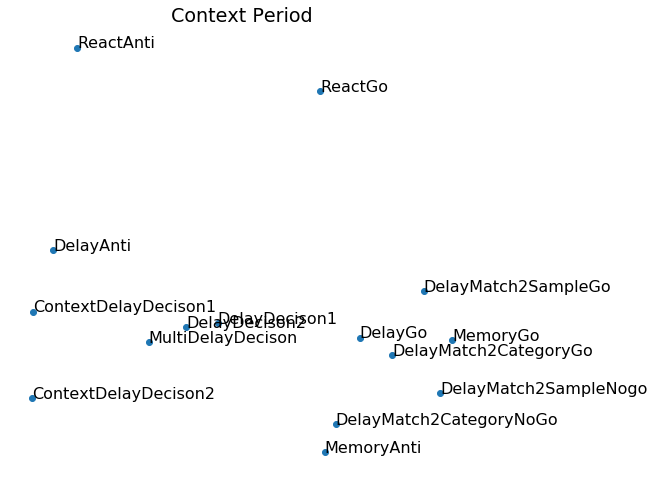

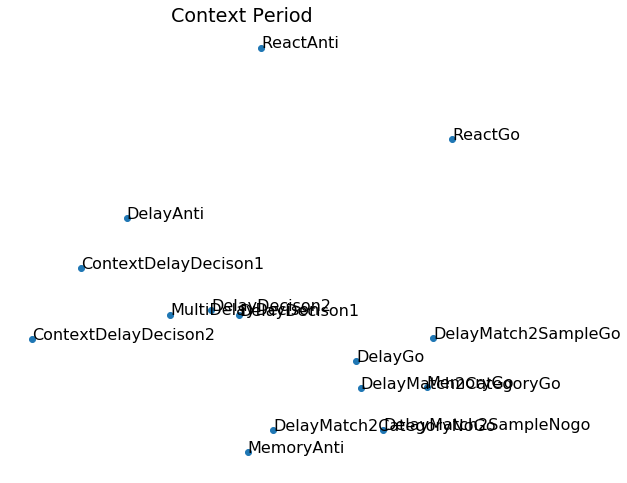

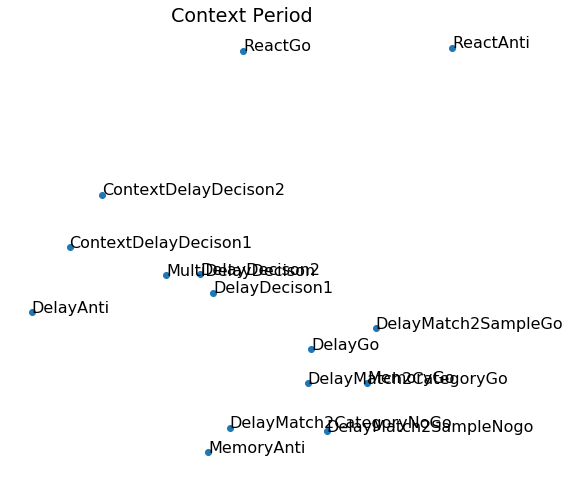

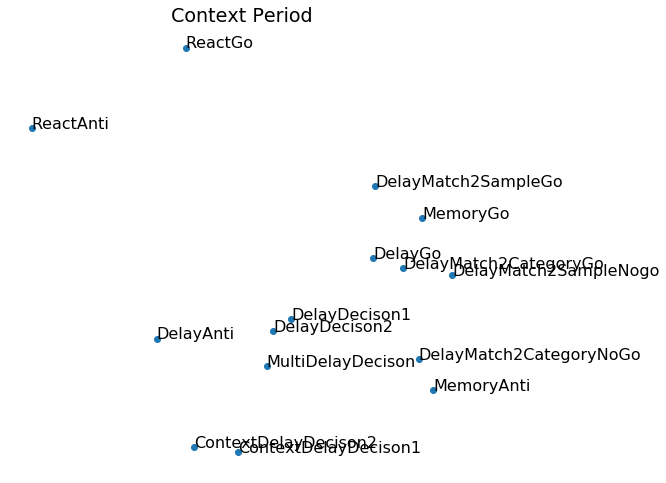

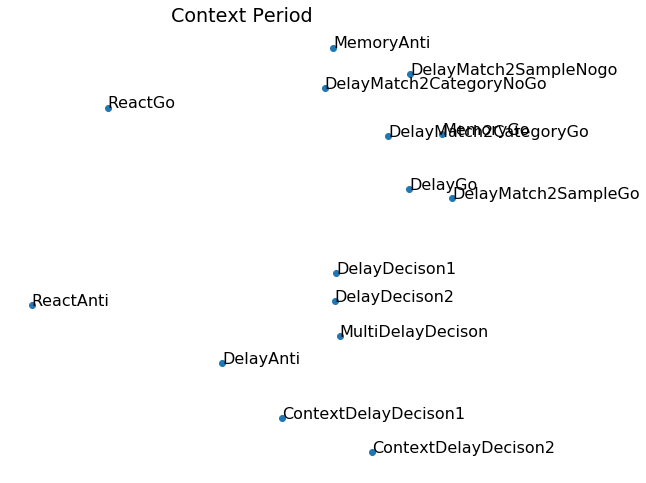

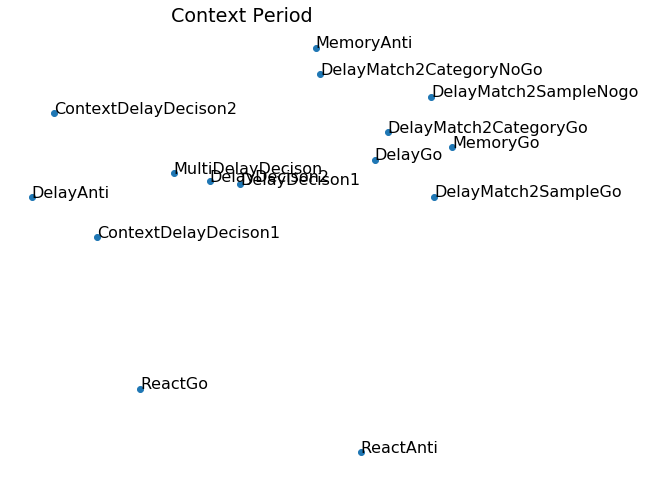

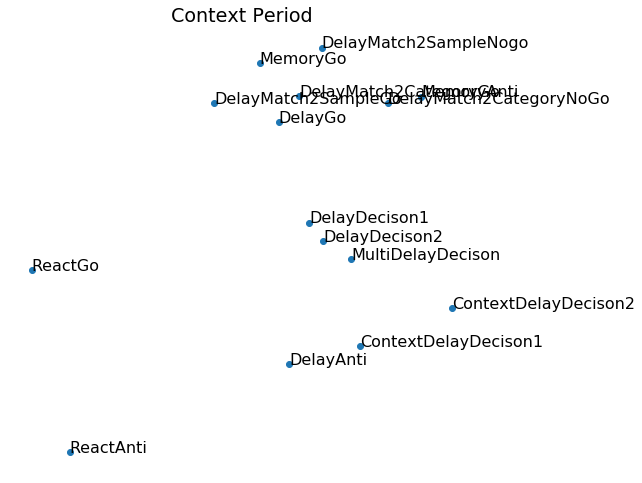

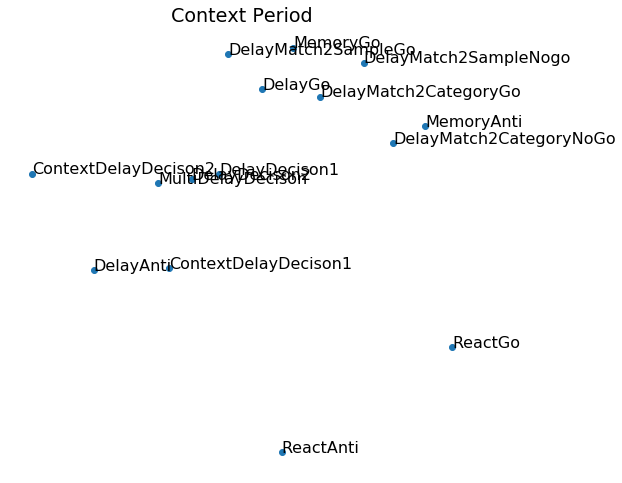

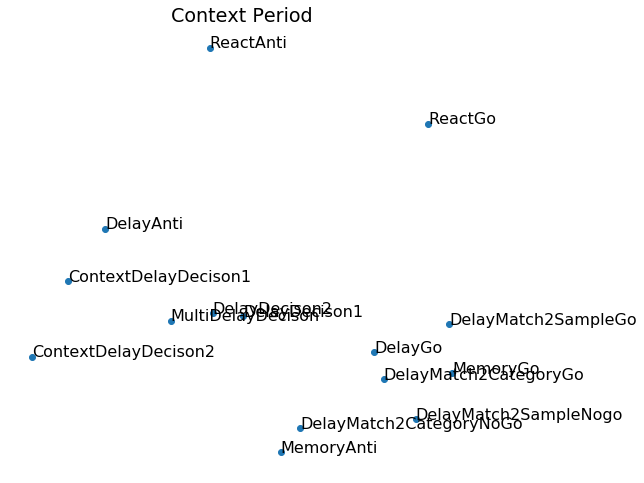

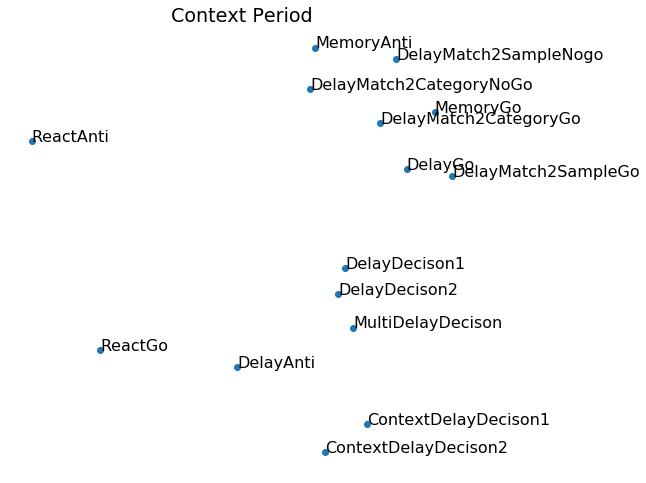

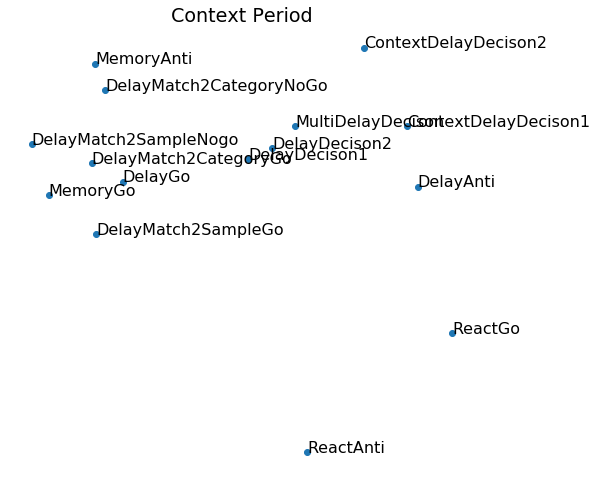

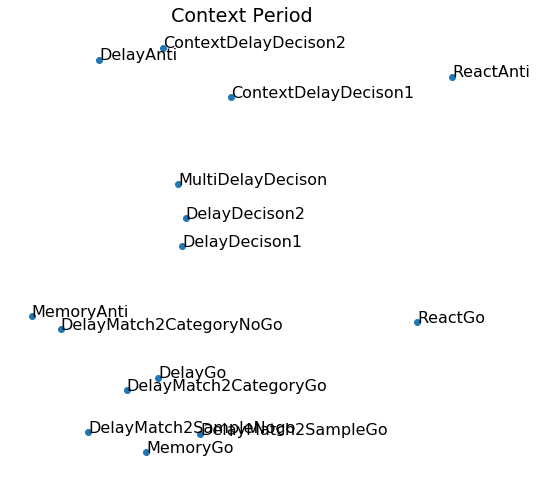

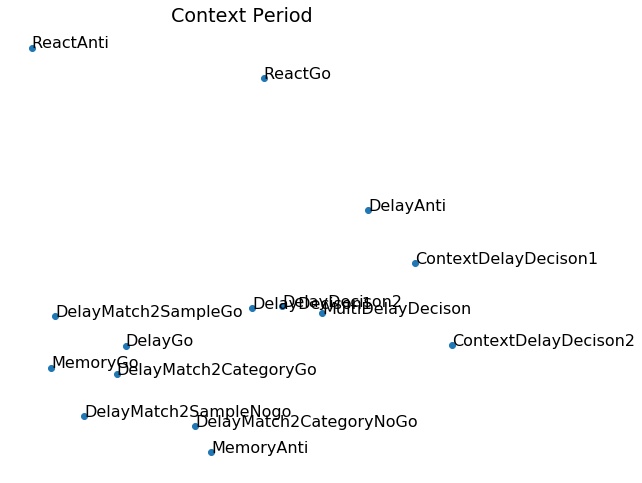

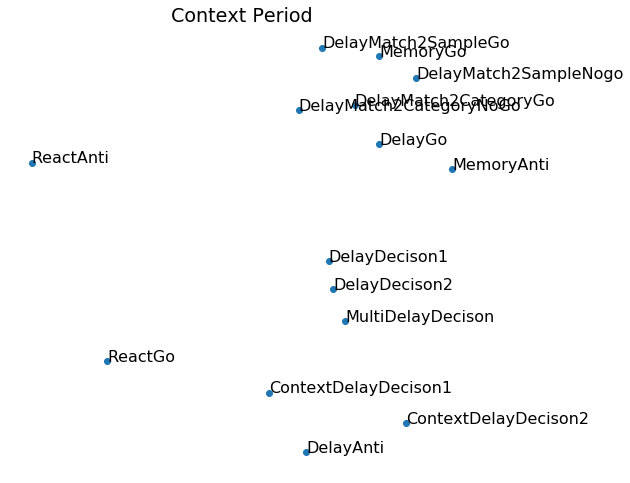

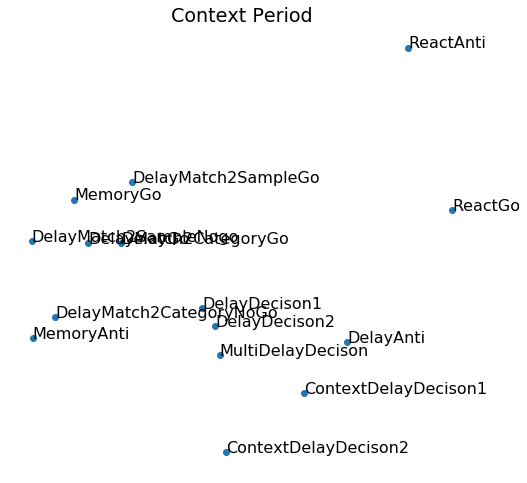

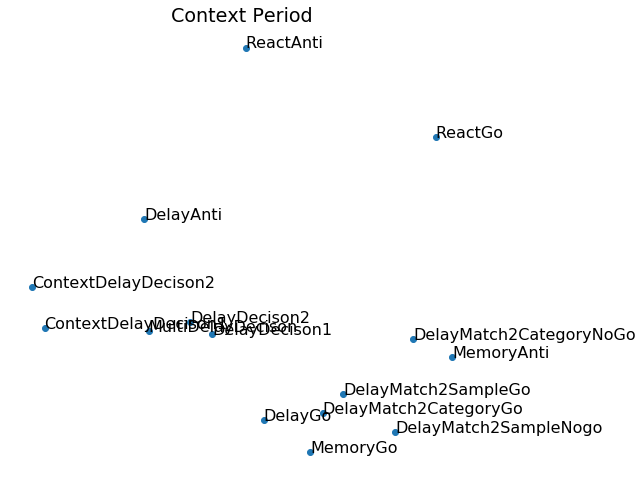

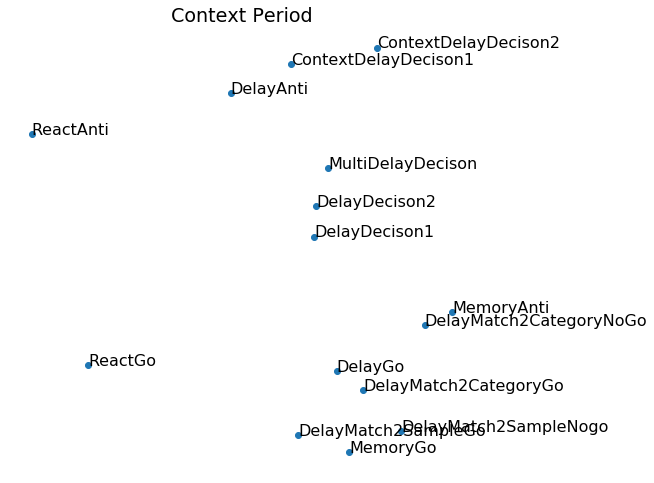

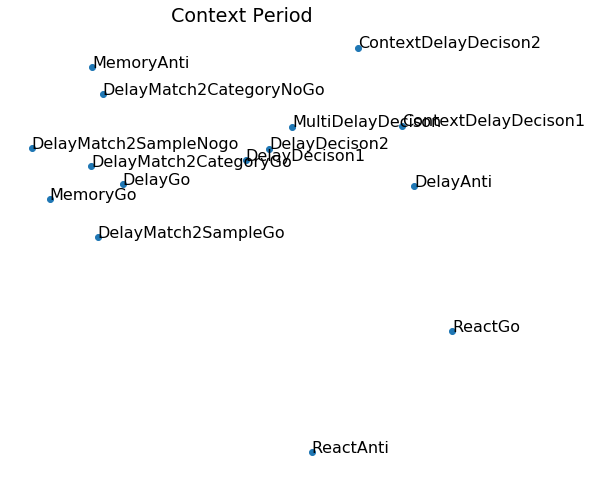

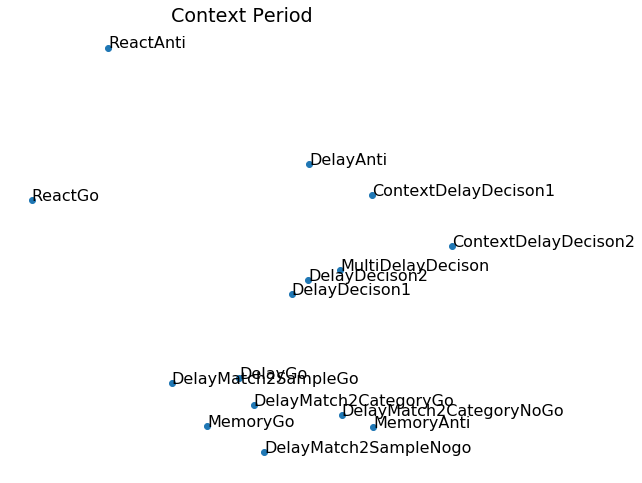

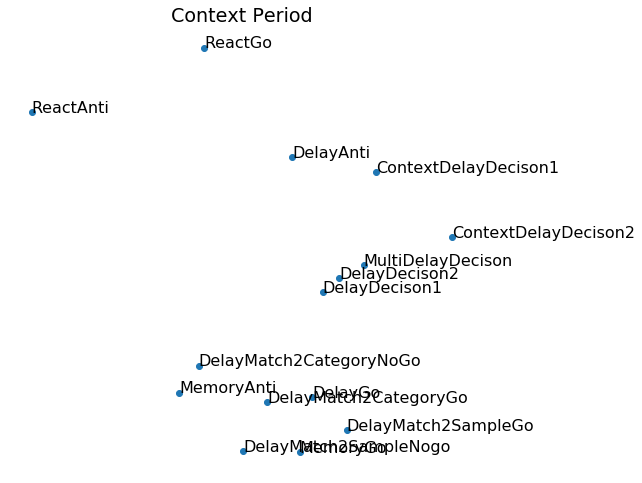

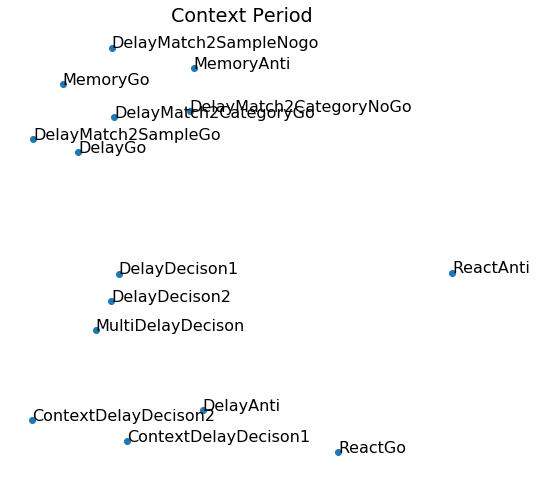

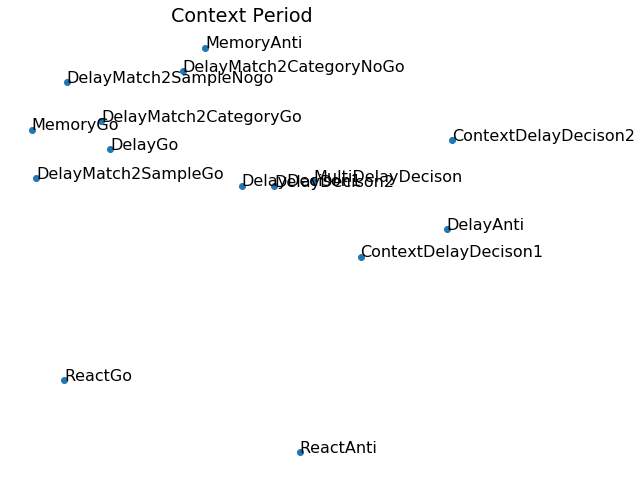

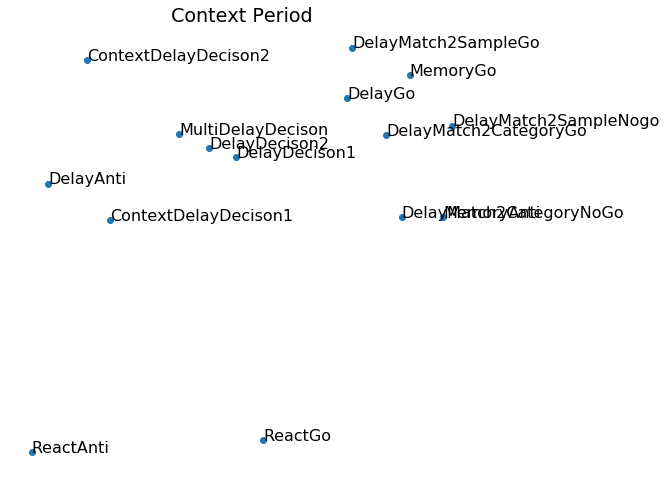

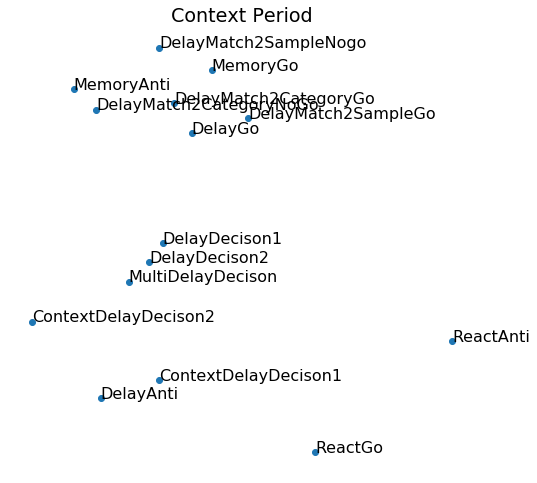

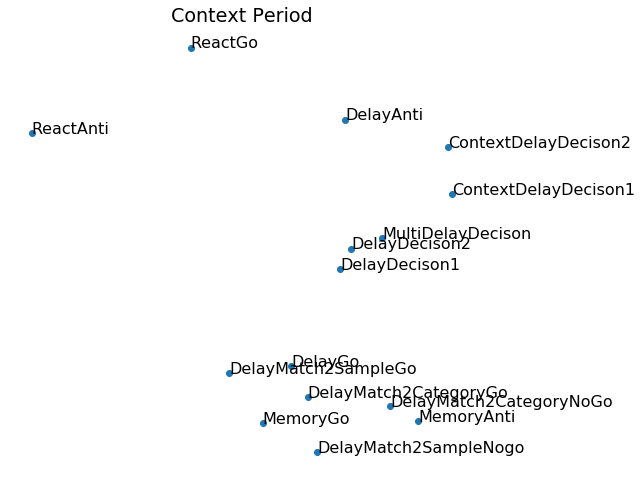

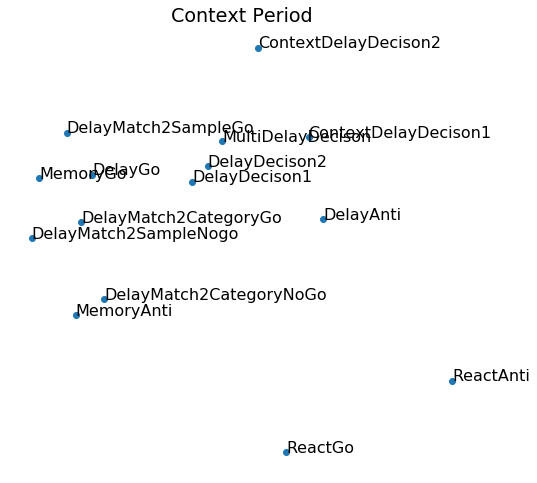

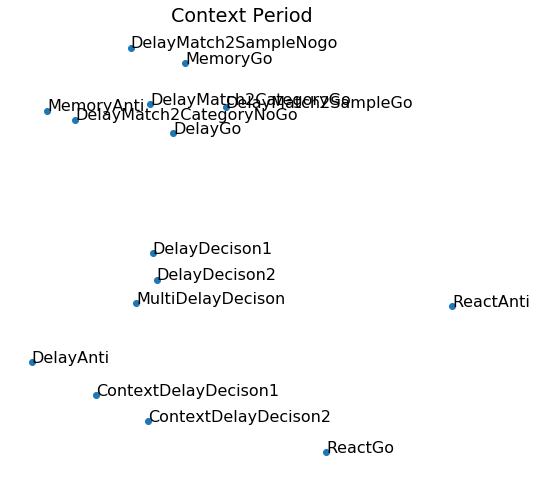

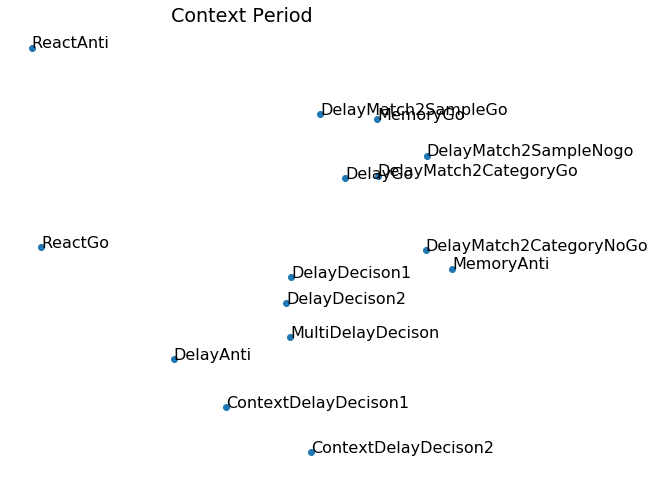

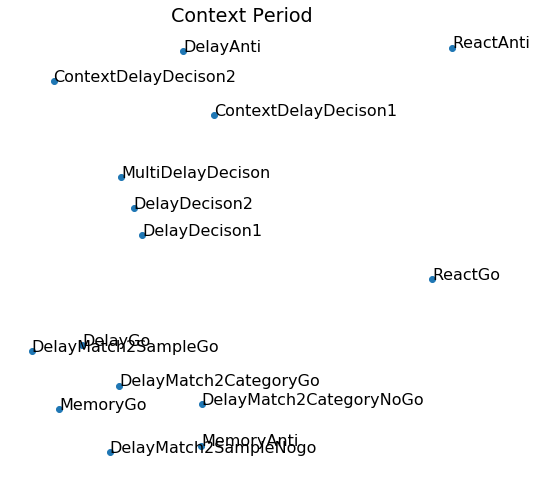

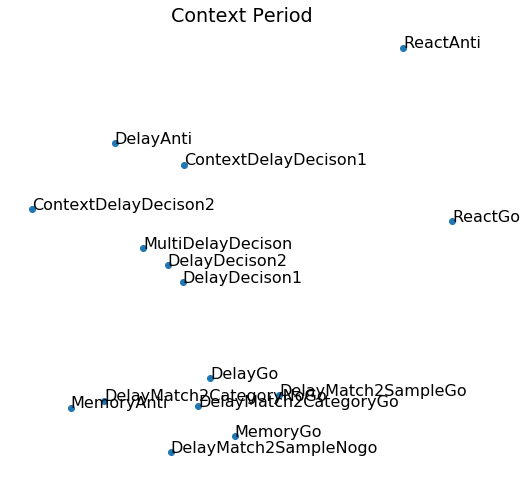

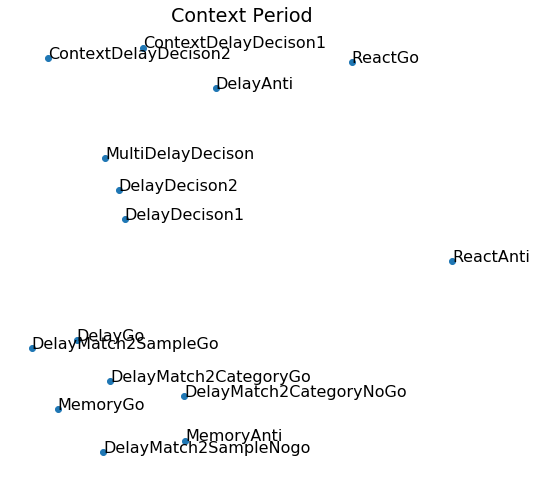

In [69]:
for bla in range(100):
    X = h_fix_combined.astype(np.float64)
    row_means = np.mean(X, axis=0)
    row_var = np.var(X, axis=0)
    X_center = X - np.tile(row_means,(X.shape[0],1))
    X_ball = np.true_divide(X - np.tile(row_means,(X.shape[0],1)), np.tile(row_var,(X.shape[0],1)))

    embedding = MDS(n_components=2)
    X_transformed = embedding.fit_transform(X_center)

    fig = plt.figure(figsize=(7, 7),tight_layout=True,facecolor='white')
    plt.rcParams.update({'font.size': 16})
    plt.plot(X_transformed[:,0],X_transformed[:,1],'o')
    for r in range(len(rule_n)):
        rule = rule_set_names[rule_n[r]]
        plt.text(X_transformed[r,0],X_transformed[r,1],rule)
    plt.title('Context Period')
#     plt.xlabel('MDS1')
#     plt.ylabel('MDS2')
    plt.box(False)
    plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
    plt.show()

In [10]:
np.array(0,1,.1)

ValueError: only 2 non-keyword arguments accepted

In [43]:
rule_set = rules_dict['all']
pulse_size = 10
All_Models_X_euc_dist = []
rule_pair = [11,12]# [11,12]

#choose number of indices to visualize
vis_before = 10
vis_after = pulse_size*3
vis_ind = vis_before + vis_after
rule_n = np.concatenate((range(6),range(11,20)),axis = 0)
    
for model_n in range(1):

    model_dir_all = os.path.join(p,'data/rnn/multitask/crystals/softplus/most',str(model_n))
    
    #generate a set of stimuli that sweep each modality
    trial1 = gen_trials_from_model_dir(model_dir_all,rules_dict['all'][rule_pair[0]])
    trial2 = gen_trials_from_model_dir(model_dir_all,rules_dict['all'][rule_pair[1]])
    trial_pulse = trial1
    trial_pulse.x = np.concatenate((trial1.x,trial2.x),axis=1)

    # set pulse size
    stim_start = trial_pulse.epochs['stim1'][0]-1
    delay_end = trial_pulse.epochs['delay1'][1]
    trial_pulse.x[stim_start+pulse_size:delay_end,:,1:5] = 0
    
    h_pulse_combined = []

    for ratio in np.linspace(0,1,11):

        trial_pulse.x[:,:,5:] = 0 #set all tasks to 0
        trial_pulse.x[:,:,5+rule_pair[0]] = ratio #vary btwn 2 tasks
        trial_pulse.x[:,:,5+rule_pair[1]] = 1-ratio

        model = Model(model_dir_all)
        with tf.Session() as sess:
            model.restore()
            # get all connection weights and biases as tensorflow variables
            var_list = model.var_list
            # evaluate the parameters after training
            params = [sess.run(var) for var in var_list]
            # get hparams
            hparams = model.hp

            # get feed_dict
            feed_dict_pulse = tools.gen_feed_dict(model, trial_pulse, hparams)
            # run model
            h_pulse, y_hat_pulse = sess.run([model.h, model.y_hat], feed_dict=feed_dict_pulse) #(n_time, n_condition, n_neuron)

            # crop in time to the part of the trial to visualize
            h_pulse_crop = h_pulse[stim_start-vis_before:stim_start+vis_after,0:-1:100,:] - h_pulse[stim_start,0:-1:100,:]
            # snapshot of activity right before stim pulse
            h_fix = np.reshape(h_pulse[stim_start,0:-1:100,:],(1,-1))
            # reshape h_pulse to stack
            h_pulse_shape = np.expand_dims(np.reshape(h_pulse_crop,(vis_ind,-1)), axis=0)

            if h_pulse_combined == []:
                h_pulse_combined = h_pulse_shape
                h_fix_combined = h_fix
            else:
                h_pulse_combined = np.concatenate((h_pulse_combined, h_pulse_shape), axis=0)
                h_fix_combined = np.concatenate((h_fix_combined, h_fix), axis=0)
        
        
        dist = DistanceMetric.get_metric('euclidean')
        
        X = h_fix_combined.astype(np.float64)
        X_euc_dist_context = np.expand_dims(dist.pairwise(X),axis=2)
        
        X_euc_dist = []
        
        for h_ind in range(np.shape(h_pulse_combined)[1]):
            X = h_pulse_combined[:,h_ind,:].astype(np.float64)

            if len(X_euc_dist)==0:
                X_euc_dist = np.expand_dims(dist.pairwise(X),axis=2)
            else:
                X_euc_dist = np.concatenate((X_euc_dist,np.expand_dims(dist.pairwise(X),axis=2)),axis = 2)
            
    if len(All_Models_X_euc_dist)==0:
        All_Models_X_euc_dist = np.expand_dims(X_euc_dist,axis=0)
        All_Models_X_euc_dist_context = np.expand_dims(X_euc_dist_context,axis=0)
    else:
        All_Models_X_euc_dist = np.concatenate((All_Models_X_euc_dist,np.expand_dims(X_euc_dist,axis=0)),axis = 0)
        All_Models_X_euc_dist_context = np.concatenate((All_Models_X_euc_dist_context,np.expand_dims(X_euc_dist_context,axis=0)),axis = 0)
            
            

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/most/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/most/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/most/0/model.ckpt
Model restored from 

/Users/lauradriscoll/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/most/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/most/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/most/0/model.ckpt
Model restored from 

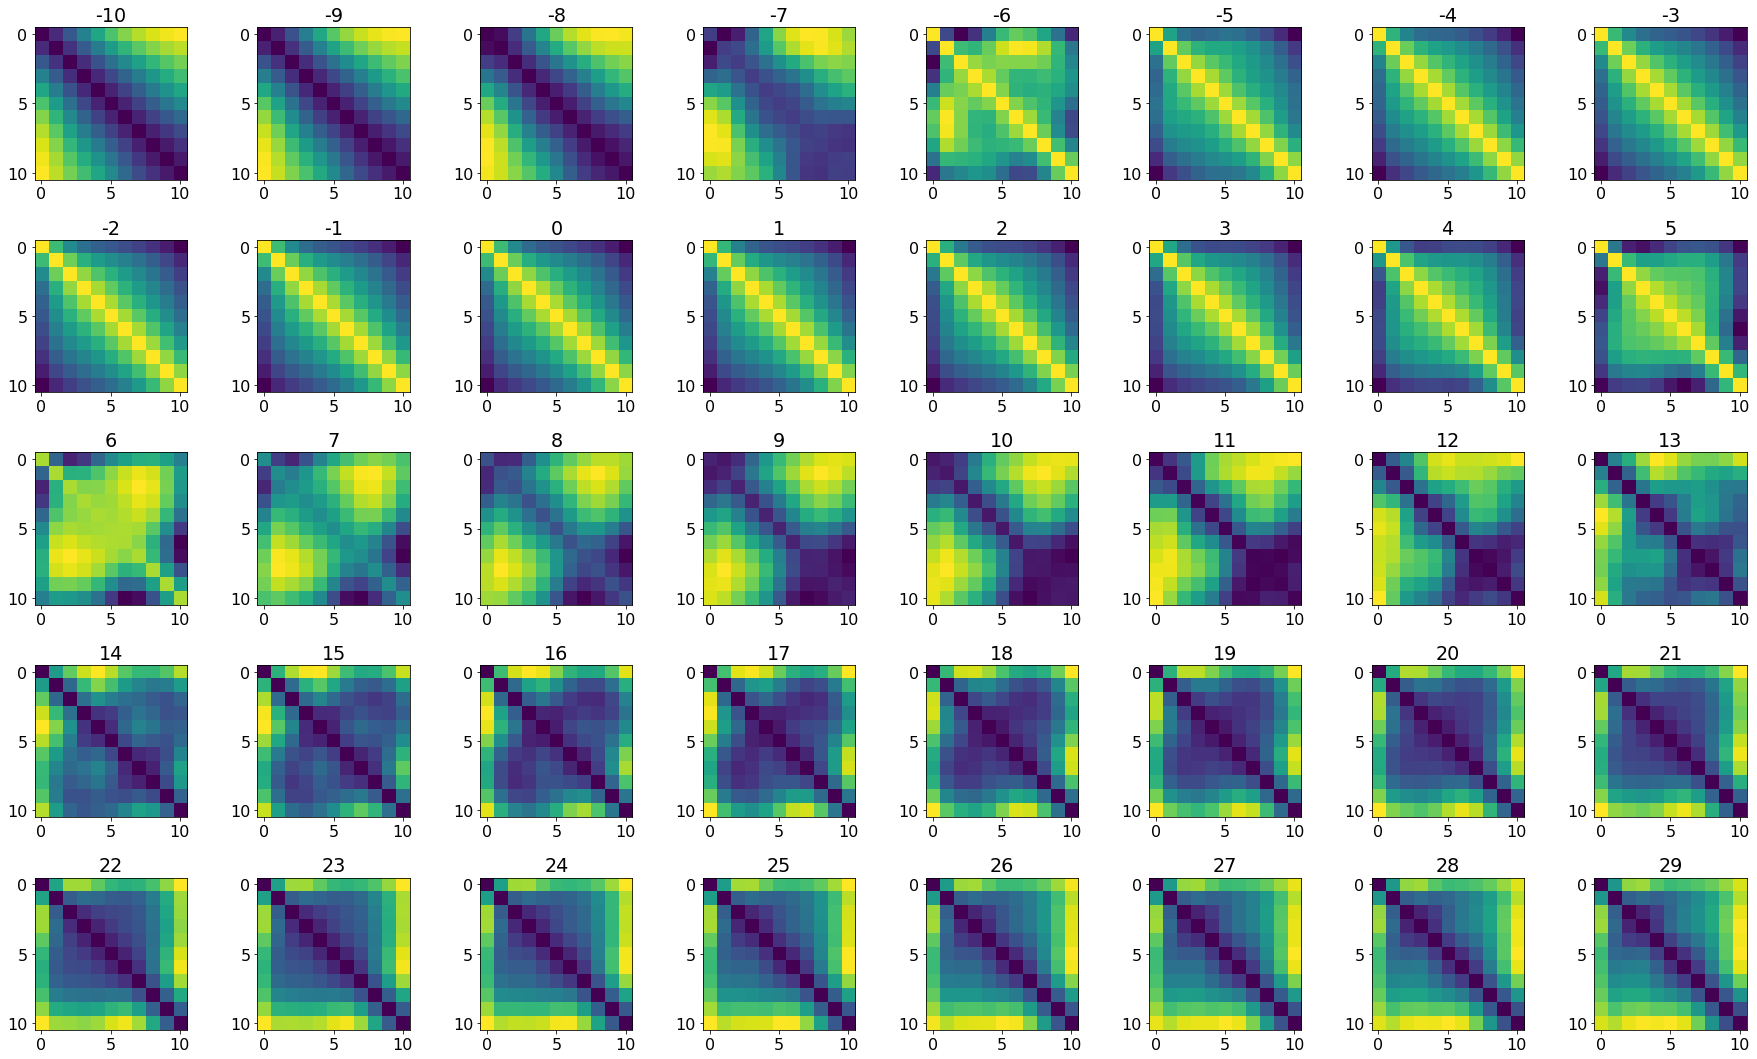

In [44]:
fig = plt.figure(figsize=(25, 15),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

for t in range(np.shape(X_euc_dist)[2]):
    ax = fig.add_subplot(5,np.ceil(np.shape(X_euc_dist)[2]/5),t+1)
    plt.imshow(X_euc_dist[:,:,t] - np.mean(X_euc_dist,axis=2))
    plt.title(t-vis_before)

plt.show()

/Users/lauradriscoll/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


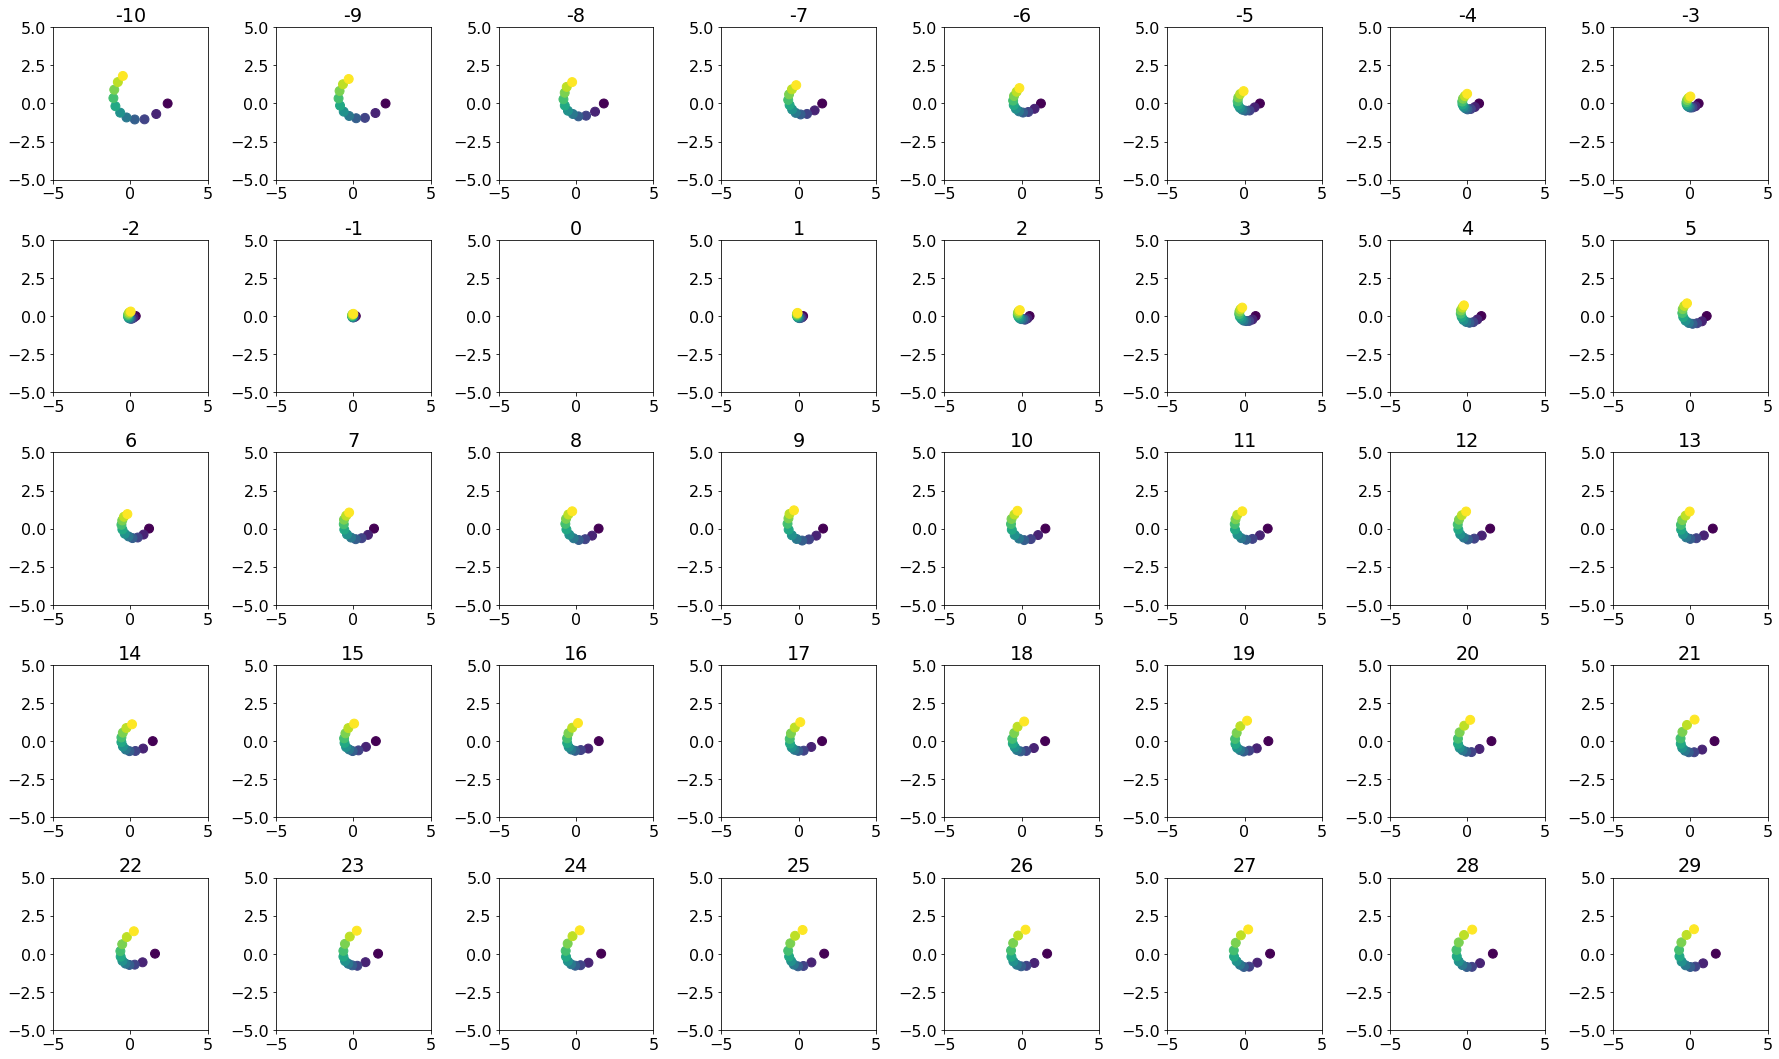

In [45]:
fig = plt.figure(figsize=(25, 15),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

for h_ind in range(np.shape(X_euc_dist)[2]):

    X = X_euc_dist[:,:,h_ind].astype(np.float64)
    
    embedding = MDS(n_components=2)
    X_transformed = embedding.fit_transform(X)
    
    v1 = np.array([1,0])
    v2 = X_transformed[0,:]
    theta = angle_between(v1, v2)
    if X_transformed[0,1]>0:
        theta = -theta
    R = rot_mat(theta)
    Xr_ss = tranform_in_rPC(X_transformed,R,X_transformed)
#     Xr_ss = X_transformed

    ax = fig.add_subplot(5,np.ceil(np.shape(X_euc_dist)[2]/5),h_ind+1)
    ax = plt.scatter(Xr_ss[:,0],Xr_ss[:,1],80,range(np.shape(Xr_ss)[0]))
    plt.title(h_ind-vis_before)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    
plt.show()

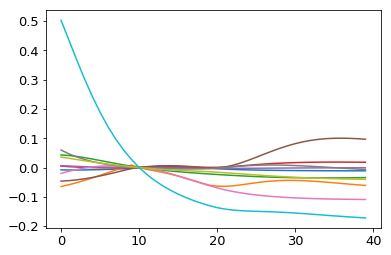

In [30]:
X = h_pulse_combined[0,:,:]
X_shape = np.reshape(X,(vis_ind,16,-1))
np.shape(X_shape)

plt.plot(X_shape[:,0,:10])
plt.show()

In [13]:
print(trial_pulse.epochs)

{'delay1': (50, 100), 'stim1': (25, 50), 'go1': (100, None), 'fix1': (None, 25)}


In [14]:
np.shape(h)
cel = 33

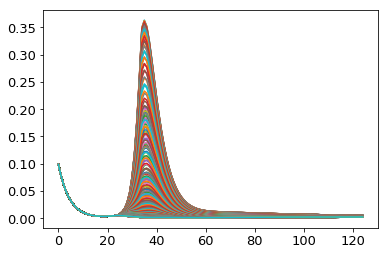

In [31]:
plt.plot(h_pulse[:,:800,cel])
plt.show()

In [24]:
print(trial.epochs)

{'delay1': (50, 100), 'stim1': (25, 50), 'go1': (100, None), 'fix1': (None, 25)}


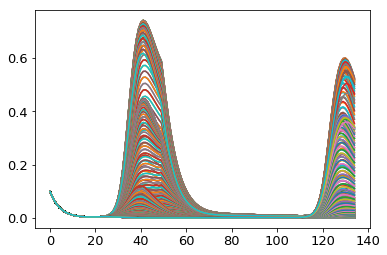

In [32]:
plt.plot(h[:,:,cel])
plt.show()

In [25]:
trial.x[25,113,1]

0.85099447

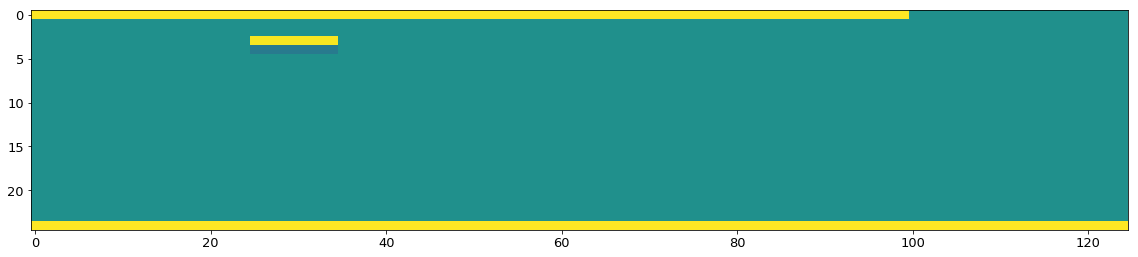

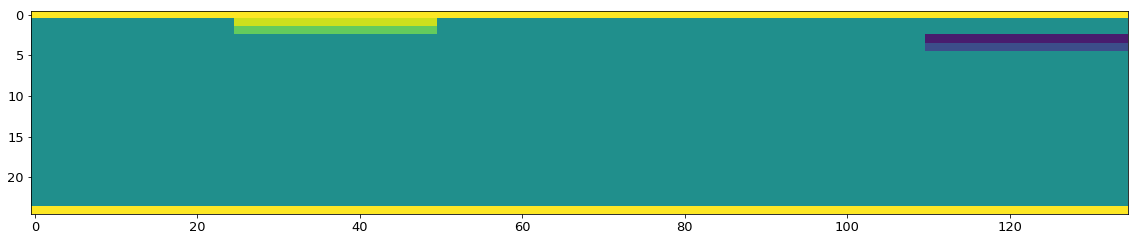

In [34]:
fig = plt.figure(figsize=(16, 16),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 13})
plt.imshow(trial_pulse.x[:,113,:].T, vmin=-1, vmax=1)
plt.show()

fig = plt.figure(figsize=(16, 16),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 13})
plt.imshow(trial.x[:,113,:].T, vmin=-1, vmax=1)
plt.show()

In [25]:
epoch = 'delay1'

trial1 = gen_trials_from_model_dir(model_dir_all,rule1)
_, x1 = gen_X_from_model_dir_epoch(model_dir_all,ckpt_n_dir,trial1,epoch)
trial1.x[trial1.epochs['stim1'][0]+1:trial1.epochs['delay1'][1],:,1:5] = 0

trial2 = gen_trials_from_model_dir(model_dir_all,rule2)
_, x2 = gen_X_from_model_dir_epoch(model_dir_all,ckpt_n_dir,trial2,epoch)
trial2.x[trial2.epochs['stim1'][0]+1:trial2.epochs['delay1'][1],:,1:5] = 0

trial3 = gen_trials_from_model_dir(model_dir_all,rule3)
_, x3 = gen_X_from_model_dir_epoch(model_dir_all,ckpt_n_dir,trial3,epoch)
trial3.x[trial3.epochs['stim1'][0]+1:trial3.epochs['delay1'][1],:,1:5] = 0

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/most/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/most/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/most/0/ckpts/model.ckpt-423000
Variabl

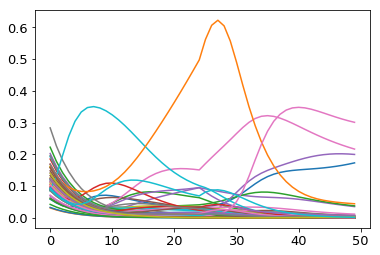

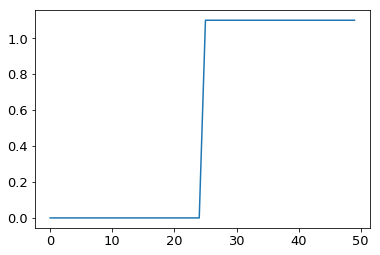

In [36]:
plt.plot(h_tf[:50,t_set,:50])
plt.show()

plt.plot(trial.x[:50,t_set,1])
plt.show()

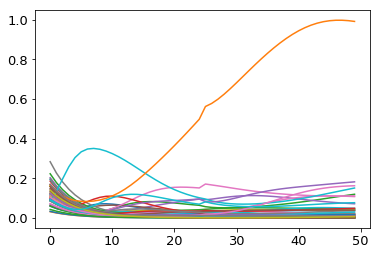

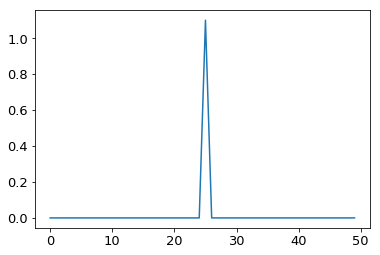

In [37]:
plt.plot(h_tf_pulse[:50,t_set,:50])
plt.show()

plt.plot(trial1.x[:50,t_set,1])
plt.show()
        

In [52]:
h1 = h_tf_pulse[trial1.epochs['stim1'][0]:trial1.epochs['stim1'][0]+3,:,:]
h2 = h_tf_pulse[trial2.epochs['stim1'][0]:trial2.epochs['stim1'][0]+3,:,:]
h3 = h_tf_pulse[trial3.epochs['stim1'][0]:trial3.epochs['stim1'][0]+3,:,:]

In [49]:
h1 = h_tf_pulse[trial1.epochs['stim1'][0]:trial1.epochs['stim1'][0]+3,:,:]

from sklearn.manifold import MDS

cmap=plt.get_cmap('tab20')
X = h0[0,:,:].astype(np.float64)
row_means = np.mean(X, axis=0)
row_var = np.var(X, axis=0)
X_center = X - np.tile(row_means,(X.shape[0],1))
X_ball = np.true_divide(X - np.tile(row_means,(X.shape[0],1)), np.tile(row_var,(X.shape[0],1)))

embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(X_center)

In [ ]:
np.shape(X_transformed)

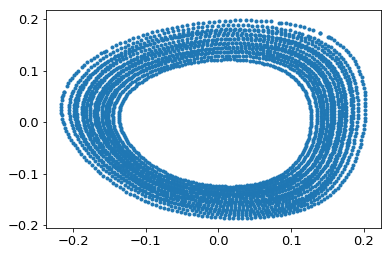

In [51]:
plt.plot(X_transformed[:,0],X_transformed[:,1],'.')
plt.show()